<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## Capstone Project: Investor Risk Tolerance Prediction and Robo-Advisory Dashboard

Project done by - **Anand Ramchandani**

# Contents:
- [Background](#Background)
- [Problem Statement](#Problem-Statement)
- [Functions Used](#Functions-Used)
- [Import Libraries](#Import-Libraries)
- [Import/Loading Data](#Import/Loading-Data)
- [Displaying the Data](#Displaying-the-Data)
- [Data Dictionary](#Data-Dictionary)
- [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
- [Feature Selection and Engineering](#Feature-Selection-and-Engineering)
- [Train Test Split](#Train-Test-Split)
- [Addressing Multicollinearity](#Addressing-Multicollinearity)
- [Model Selection](#Model-Selection)
- [Hyperparameter Tuning](#Hyperparameter-Tuning)
- [Random Forest Model](#Random-Forest-Model)
- [Model Performance Evaluation](#Model-Performance-Evaluation)
- [Feature Importance](#Feature-Importance)
- [Shapley Values for Model Interpretation](#Shapley-Values-for-Model-Interpretation)
- [Limitations](#Limitations)
- [Conclusions](#Conclusions)
- [Recommendations](#Recommendations)

# Background

**Problem Observed**
- When trying to create a risk assessment for each client, financial advisors deploy long and tedious questionnaires or surveys that require a lot of manual input and time from the investor.
- Studies have shown that these questionnaires are often prone to error because investors suffer from behavioural biases and are poor judges of their own risk perceptions, especially during times of financial turmoil. 
- Some studies have even show that the risk profiling questionnaire process helps in enabling behavioural biases

**Background regarding Risk Profiling**
- Risk tolerance measures subjective aspects of risk tolerance, including a investors personality, how they react to real or potential losses, and what their goals and priorities are
- Capacity or Ability to take risk measures objective factors like time horizon, need for income and family situation

**Questions on using Machine Learning to address this issue**
- Can machine learning provide a better assessment of an investors risk profile than a risk tolerance questionnaire?
- Can the machine learning algorithm better reflect how a client would deal in different financial market scenarios?
- Can we automate the investment and portfolio management process with minimal need for human intervention?

**Solution and Aim of this Project**
- To create a supervised regression-based machine learning model that is able to predict an individual investors risk tolerance. 
- Coupled with the individuals stated willingness to take risk, a robo advisory dashboard will be created using the model to recommend a portfolio based on that predicted risk tolerance.

**Target and Predictor Variables**
- The target predicted variable is the true Risk Tolerance of the investor. 
- The predictor variables are the other household demographic and financial attributes of the investor.

**Source of Dataset**
- The dataset used comes from the Survey of Consumer Finances, which is a statistical survey taken by the Federal Reserve every 3 years. 
- It contains the balance sheet, income and other household demographics of families in the United States. 
- The latest dataset was taken in 2019, which covers data on households from 2017 to 2019.
https://www.federalreserve.gov/econres/scfindex.htm
- We have datasets that go back to 2007

**How do we find the true risk tolerance of the individual?**

- We know that the ratio of risky assets to the total assets of an investor is a measure of the risk tolerance of that investor
- Risky Assets include investments in mutual funds, stocks, bonds, commodities, real estate, etc.
- Risk-Free Assets include checking and savings balances, certificates of deposit, and other cash balances and equivalents
- Using the data obtained in the Survey of Consumer Finances we can calculate the True Risk Tolerance and use that as the target predicted variable

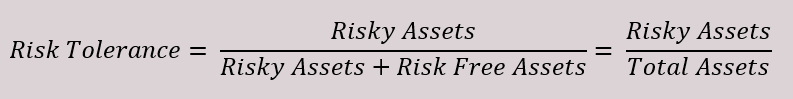

**Links to Studies showing relationship between Risk Tolerance Questionnaires and Behavioural Biases**
- https://www.cfainstitute.org/-/media/documents/article/rf-brief/rfbr-v2-n1-1-pdf.ashx
- https://www.kitces.com/blog/risk-tolerance-questionnaire-and-risk-profiling-problems-for-financial-advisors-planplus-study/
- https://assets.ey.com/content/dam/ey-sites/ey-com/en_us/topics/wealth-and-asset-management/ey-behavioral-finance-whitepaper-v1.pdf?download

**Attributes of Investors that can be used as Features to Predict Investor's Risk Tolerance**

- We can see some common attributes like those listed below that could be correlated with an investors risk tolernace which can be used for prediction

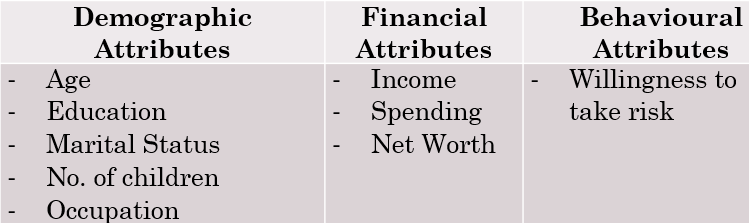

# Problem Statement

A Robo Advisory company would like to avoid using long and tedious risk questionnaires or surveys that require a lot of manual input to asses their clients risk profiles. They also realise these questionnaires are often prone to error because investors suffer from behavioural biases and are poor judges of their own risk perceptions especially during times of financial turmoil. 

The have hired a data scientist to create a machine learning model that is able to predict an individual investors risk tolerance from key feature attributes. Along with the individuals stated willingness to take risk, a robo advisory dashboard will also be created using the model to recommend a portfolio based on that predicted risk tolerance.

# Functions Used

In [29]:
# Function used for Distribution Plots
def distribution_plot(y):
  (mu,sigma) = norm.fit(y)
  print(f'mu = {round(mu,2)}, sigma = {round(sigma,2)}, skew = {y.skew()}')
  f, ax = plt.subplots(figsize=(10,5))
  ax = sns.distplot(y, fit=norm)
  plt.xlabel('RiskTolerance', fontsize=15)
  plt.ylabel('Frequency', fontsize=15)
  plt.title('Distribution of Risk Tolerance', fontsize=15)
  plt.show()

In [30]:
# Function used for Variance Inflation Factor (VIF)
def VIF(data):  
  vif_data = pd.DataFrame()
  num_idx = data.select_dtypes(include = ['int64', 'float64']).columns
  vif_data['feature'] = num_idx
  vif_data['VIF'] = [variance_inflation_factor(data[num_idx].values, i) for i in range(len(num_idx))]
  return vif_data[vif_data['VIF']>10]

# Import Libraries

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import copy 
import shap

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import norm

# Importing models from sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Ridge, Lasso, ElasticNet, ElasticNetCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.neural_network import MLPRegressor

# Importing Libraries for Model Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Importing Libraries for Statistical Models
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Importing Pickle Libraries in order to save the model
from pickle import dump
from pickle import load

# Import/Loading Data

In [33]:
# Loading Dataset for 2019 Survey of Consumer Finances (SCF) 
data19 = pd.read_csv('data/SCFP2019.csv')
data16 = pd.read_csv('data/SCFP2016.csv')
data13 = pd.read_csv('data/SCFP2013.csv')
data10 = pd.read_csv('data/SCFP2010.csv')
data09 = pd.read_excel('data/SCFP2009panel.xlsx')

## Reasons for Year Range Selection

### Pros
- We choose survey datasets over a 12 year range in order to eliminate the effects of market conditions on our Machine Learning model
- That is to say any major market economic events like: political turmoil, financial crises, interest rake hites or drops will have less of a bearing on the predictive behaviour of the risk tolerance of individual investors as these will be taken into account

### Cons
- Taking a 12 year historical range of data exposes us to data drift. Data drift is the change in model input data that leads to model performance degradation.
- For example, the average annual income of americans in 2010 are different from those in 2019, which has an impact on the model output, not to mention the number of marriages, kids, etc. Which all could be pertinent factors in decidicing Risk Tolerance

We mention this here to keep in mind the assumptions and limitations of our model

# Displaying the Data

## 2019 Dataset

In [34]:
# Looking at the top 5 rows 
data19.head()

,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
0,1,11,6119.779308,2,75,6,12,4,2,0,...,5,3,6,3,2,10,6,6,3,3
1,1,12,4712.374912,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
2,1,13,5145.224455,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
3,1,14,5297.663412,2,75,6,12,4,2,0,...,5,2,6,2,1,10,4,4,2,2
4,1,15,4761.812371,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2


In [35]:
# Looking at the bottom 5 rows 
data19.tail()

,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
28880,5813,58131,667.098300,1,51,3,5,1,1,0,...,5,6,6,6,3,11,11,11,4,4
28881,5813,58132,678.821856,1,51,3,5,1,1,0,...,5,6,6,6,3,11,11,11,4,4
28882,5813,58133,640.908142,1,51,3,5,1,1,0,...,5,6,6,6,3,11,11,11,4,4
28883,5813,58134,665.152072,1,51,3,5,1,1,0,...,5,6,6,6,3,11,11,11,4,4
28884,5813,58135,662.401934,1,51,3,5,1,1,0,...,5,6,6,6,3,11,11,11,4,4


In [36]:
# Seeing the shape of the data
data19.shape

(28885, 351)

- We can see 28,885 rows and 351 columns

In [37]:
# Describe the data
data19.describe()

,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
count,28885.000000,28885.000000,28885.000000,28885.000000,28885.000000,28885.000000,28885.000000,28885.000000,28885.000000,28885.000000,...,28885.000000,28885.000000,28885.000000,28885.000000,28885.000000,28885.000000,28885.000000,28885.000000,28885.000000,28885.000000
mean,2906.446945,29067.469448,4453.606750,1.223819,53.219837,3.388783,10.247395,3.073394,1.375974,0.748312,...,3.075022,3.654146,3.666713,3.666332,1.864532,6.717050,6.683157,6.713969,2.798823,2.809244
std,1678.234066,16782.340720,2815.046077,0.416809,16.243653,1.546648,2.700152,1.008865,0.484382,1.123829,...,1.509840,1.806267,1.858337,1.800673,0.794989,3.612269,3.532322,3.525801,1.168914,1.164626
min,1.000000,11.000000,1.442477,1.000000,18.000000,1.000000,-1.000000,1.000000,1.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1452.000000,14522.000000,2098.599956,1.000000,40.000000,2.000000,8.000000,2.000000,1.000000,0.000000,...,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,4.000000,4.000000,2.000000,2.000000
50%,2906.000000,29063.000000,4761.795033,1.000000,54.000000,3.000000,11.000000,3.000000,1.000000,0.000000,...,3.000000,4.000000,4.000000,4.000000,2.000000,7.000000,7.000000,7.000000,3.000000,3.000000
75%,4359.000000,43594.000000,6179.113347,1.000000,65.000000,5.000000,12.000000,4.000000,2.000000,1.000000,...,5.000000,6.000000,6.000000,6.000000,3.000000,10.000000,10.000000,10.000000,4.000000,4.000000
max,5813.000000,58135.000000,14827.320644,2.000000,95.000000,6.000000,14.000000,4.000000,2.000000,7.000000,...,5.000000,6.000000,6.000000,6.000000,3.000000,12.000000,12.000000,12.000000,4.000000,4.000000


In [38]:
# Data info
data19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28885 entries, 0 to 28884
Columns: 351 entries, YY1 to NINCQRTCAT
dtypes: float64(74), int64(277)
memory usage: 77.4 MB


In [39]:
# Checking the data types
pd.set_option('display.max_columns', 400)
pd.set_option('display.max_rows', 400)
data19.dtypes

YY1                int64
Y1                 int64
WGT              float64
HHSEX              int64
AGE                int64
AGECL              int64
EDUC               int64
EDCL               int64
MARRIED            int64
KIDS               int64
LF                 int64
LIFECL             int64
FAMSTRUCT          int64
RACECL             int64
RACECL4            int64
RACE               int64
OCCAT1             int64
OCCAT2             int64
INDCAT             int64
FOODHOME           int64
FOODAWAY           int64
FOODDELV           int64
RENT             float64
INCOME           float64
WAGEINC          float64
BUSSEFARMINC     float64
INTDIVINC        float64
KGINC            float64
SSRETINC         float64
TRANSFOTHINC     float64
PENACCTWD        float64
NORMINC          float64
WSAVED             int64
SAVED              int64
SAVRES1            int64
SAVRES2            int64
SAVRES3            int64
SAVRES4            int64
SAVRES5            int64
SAVRES6            int64


- Given that the data is from the US Federal Reserve website, the data is quite clean and are all numerical. So we do not need to convert any categorical variables

In [40]:
# Checking Null Values
data19.isnull().sum().sort_values(ascending=False).reset_index()

,index,0
0,WILSH,5
1,YY1,0
2,MRTHEL,0
3,RESDBT,0
4,MORT3,0
5,MORT2,0
6,MORT1,0
7,HOTHLOC,0
8,OTHLOC,0
9,HELOC_YN,0


- Wilshire index of stock prices (WILSH) has 5 null values

## 2016 Dataset

In [41]:
# Looking at the top 5 rows 
data16.head()

,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,LF,LIFECL,FAMSTRUCT,RACECL,RACECL4,RACE,OCCAT1,OCCAT2,INDCAT,FOODHOME,FOODAWAY,FOODDELV,RENT,INCOME,WAGEINC,BUSSEFARMINC,INTDIVINC,KGINC,SSRETINC,TRANSFOTHINC,PENACCTWD,NORMINC,WSAVED,SAVED,SAVRES1,SAVRES2,SAVRES3,SAVRES4,SAVRES5,SAVRES6,SAVRES7,SAVRES8,SAVRES9,SPENDMOR,SPENDLESS,EXPENSHILO,LATE,LATE60,HPAYDAY,BNKRUPLAST5,KNOWL,YESFINRISK,NOFINRISK,CRDAPP,TURNDOWN,FEARDENIAL,TURNFEAR,FORECLLAST5,EMERGBORR,EMERGSAV,EMERGPSTP,EMERGCUT,HBORRFF,HBORRCC,HBORRALT,HBORRFIN,HSAVFIN,HSAVNFIN,HPSTPPAY,HPSTPLN,HPSTPOTH,HCUTFOOD,HCUTENT,HCUTOTH,FINLIT,BSHOPNONE,BSHOPGRDL,BSHOPMODR,ISHOPNONE,ISHOPGRDL,ISHOPMODR,BCALL,BMAGZNEWS,BMAILADTV,BINTERNET,BFRIENDWORK,BFINPRO,BSELF,BDONT,BOTHER,ICALL,IMAGZNEWS,IMAILADTV,IINTERNET,IFRIENDWORK,IFINPRO,ISELF,IDONT,IOTHER,BFINPLAN,IFINPLAN,INTERNET,CHECKING,HCHECK,NOCHK,EHCHKG,WHYNOCKG,DONTWRIT,MINBAL,DONTLIKE,SVCCHG,CANTMANG,NOMONEY,CREDIT,DONTWANT,OTHER,CKLOCATION,CKLOWFEEBAL,CKMANYSVCS,CKRECOMFRND,CKPERSONAL,CKCONNECTN,CKLONGTIME,CKSAFETY,CKCONVPAYRL,CKOTHCHOOSE,PREPAID,SAVING,HSAVING,MMDA,MMMF,MMA,HMMA,CALL,HCALL,LIQ,HLIQ,CDS,HCDS,STMUTF,TFBMUTF,GBMUTF,OBMUTF,COMUTF,OMUTF,NMMF,HNMMF,STOCKS,HSTOCKS,NSTOCKS,WILSH,NOTXBND,MORTBND,GOVTBND,OBND,BOND,HBOND,IRAKH,THRIFT,FUTPEN,CURRPEN,RETQLIQ,HRETQLIQ,ANYPEN,DBPLANCJ,DCPLANCJ,DBPLANT,BPLANCJ,SAVBND,HSAVBND,CASHLI,HCASHLI,ANNUIT,TRUSTS,OTHMA,HOTHMA,OTHFIN,HOTHFIN,EQUITY,HEQUITY,DEQ,RETEQ,EQUITINC,HBROK,HTRAD,NTRAD,FIN,HFIN,VEHIC,HVEHIC,BUSVEH,NBUSVEH,OWN,NOWN,LEASE,NLEASE,VLEASE,NVEHIC,NEWCAR1,NEWCAR2,FARMBUS,HOUSES,HHOUSES,HOUSECL,ORESRE,HORESRE,NNRESRE,HNNRESRE,BUS,ACTBUS,NONACTBUS,HBUS,OTHNFIN,HOTHNFIN,NFIN,HNFIN,NHNFIN,ASSET,HASSET,HELOC,MRTHEL,NH_MORT,HOMEEQ,HMRTHEL,HHELOC,HNH_MORT,HPRIM_MORT,PURCH1,REFIN_EVER,HEXTRACT_EVER,HSEC_MORT,PURCH2,HMORT2,HELOC_YN,OTHLOC,HOTHLOC,MORT1,MORT2,MORT3,RESDBT,HRESDBT,CCBAL,NOCCBAL,HCCBAL,VEH_INST,EDN_INST,INSTALL,OTH_INST,HVEH_INST,HEDN_INST,HOTH_INST,HINSTALL,ODEBT,HODEBT,DEBT,HDEBT,NETWORTH,LEVRATIO,DEBT2INC,KGHOUSE,KGORE,KGBUS,FARMBUS_KG,KGSTMF,KGTOTAL,PAYMORT1,PAYMORT2,PAYMORT3,PAYMORTO,PAYLOC1,PAYLOC2,PAYLOC3,PAYLOCO,PAYHI1,PAYHI2,PAYLC1,PAYLC2,PAYLCO,PAYORE1,PAYORE2,PAYOREV,PAYORE3,PAYVEH1,PAYVEH2,PAYVEH3,PAYVEH4,PAYVEHM,PAYVEO1,PAYVEO2,PAYVEOM,PAYEDU1,PAYEDU2,PAYEDU3,PAYEDU4,PAYEDU5,PAYEDU6,PAYEDU7,PAYILN1,PAYILN2,PAYILN3,PAYILN4,PAYILN5,PAYILN6,PAYILN7,PAYMARG,PAYINS,PAYPEN1,PAYPEN2,PAYPEN3,PAYPEN4,PAYPEN5,PAYPEN6,TPAY,MORTPAY,CONSPAY,REVPAY,PIRTOTAL,PIRMORT,PIRCONS,PIRREV,PIR40,PLOAN1,PLOAN2,PLOAN3,PLOAN4,PLOAN5,PLOAN6,PLOAN7,PLOAN8,LLOAN1,LLOAN2,LLOAN3,LLOAN4,LLOAN5,LLOAN6,LLOAN7,LLOAN8,LLOAN9,LLOAN10,LLOAN11,LLOAN12,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
0,1,11,6427.136675,2,71,5,10,3,2,0,0,6,3,1,1,1,3,4,4,1914.43038,255.257384,0.0,0.0,14004.770629,0.0,0.0,0.0,0.0,9695.610436,4201.431189,0.0,14004.770629,2,0,0,0,0,0,0,0,1,0,0,5,1,3,0,0,0,0,10,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,319.07173,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0,319.07173,1,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,21700,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0,23398.59353,1,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0,0,23717.66526,1,5105.147679,1,0,0,1,1,0,0,0.0,1,0,0,0.0,159535.86498,1,1,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0,164641.01266,1,5429.694339,188358.67792,1,0.0,0.0,0.0,159535.86498,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,0,0.0,0,404.157525,0,1,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,404.157525,1,187954.52039,0.002146,0.028859,-35097.8903,0.0,0.0,0.0,0.0,-35097.8903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,10.103938,0.0,0.0,10.103938,0.008658,0.0,0.0,0.008658,0,0.0,0.0,0.0,404.157525,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,404.157525,0.0,0.0,3,1,3,1,1,7,1,1,1,1
1,1,12,6428.3505

In [42]:
# Seeing the shape of the data
data16.shape

(31240, 351)

- We can see 31,240 rows and 351 columns

In [43]:
# Describe the data
data16.describe()

,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,LF,LIFECL,FAMSTRUCT,RACECL,RACECL4,RACE,OCCAT1,OCCAT2,INDCAT,FOODHOME,FOODAWAY,FOODDELV,RENT,INCOME,WAGEINC,BUSSEFARMINC,INTDIVINC,KGINC,SSRETINC,TRANSFOTHINC,PENACCTWD,NORMINC,WSAVED,SAVED,SAVRES1,SAVRES2,SAVRES3,SAVRES4,SAVRES5,SAVRES6,SAVRES7,SAVRES8,SAVRES9,SPENDMOR,SPENDLESS,EXPENSHILO,LATE,LATE60,HPAYDAY,BNKRUPLAST5,KNOWL,YESFINRISK,NOFINRISK,CRDAPP,TURNDOWN,FEARDENIAL,TURNFEAR,FORECLLAST5,EMERGBORR,EMERGSAV,EMERGPSTP,EMERGCUT,HBORRFF,HBORRCC,HBORRALT,HBORRFIN,HSAVFIN,HSAVNFIN,HPSTPPAY,HPSTPLN,HPSTPOTH,HCUTFOOD,HCUTENT,HCUTOTH,FINLIT,BSHOPNONE,BSHOPGRDL,BSHOPMODR,ISHOPNONE,ISHOPGRDL,ISHOPMODR,BCALL,BMAGZNEWS,BMAILADTV,BINTERNET,BFRIENDWORK,BFINPRO,BSELF,BDONT,BOTHER,ICALL,IMAGZNEWS,IMAILADTV,IINTERNET,IFRIENDWORK,IFINPRO,ISELF,IDONT,IOTHER,BFINPLAN,IFINPLAN,INTERNET,CHECKING,HCHECK,NOCHK,EHCHKG,WHYNOCKG,DONTWRIT,MINBAL,DONTLIKE,SVCCHG,CANTMANG,NOMONEY,CREDIT,DONTWANT,OTHER,CKLOCATION,CKLOWFEEBAL,CKMANYSVCS,CKRECOMFRND,CKPERSONAL,CKCONNECTN,CKLONGTIME,CKSAFETY,CKCONVPAYRL,CKOTHCHOOSE,PREPAID,SAVING,HSAVING,MMDA,MMMF,MMA,HMMA,CALL,HCALL,LIQ,HLIQ,CDS,HCDS,STMUTF,TFBMUTF,GBMUTF,OBMUTF,COMUTF,OMUTF,NMMF,HNMMF,STOCKS,HSTOCKS,NSTOCKS,WILSH,NOTXBND,MORTBND,GOVTBND,OBND,BOND,HBOND,IRAKH,THRIFT,FUTPEN,CURRPEN,RETQLIQ,HRETQLIQ,ANYPEN,DBPLANCJ,DCPLANCJ,DBPLANT,BPLANCJ,SAVBND,HSAVBND,CASHLI,HCASHLI,ANNUIT,TRUSTS,OTHMA,HOTHMA,OTHFIN,HOTHFIN,EQUITY,HEQUITY,DEQ,RETEQ,EQUITINC,HBROK,HTRAD,NTRAD,FIN,HFIN,VEHIC,HVEHIC,BUSVEH,NBUSVEH,OWN,NOWN,LEASE,NLEASE,VLEASE,NVEHIC,NEWCAR1,NEWCAR2,FARMBUS,HOUSES,HHOUSES,HOUSECL,ORESRE,HORESRE,NNRESRE,HNNRESRE,BUS,ACTBUS,NONACTBUS,HBUS,OTHNFIN,HOTHNFIN,NFIN,HNFIN,NHNFIN,ASSET,HASSET,HELOC,MRTHEL,NH_MORT,HOMEEQ,HMRTHEL,HHELOC,HNH_MORT,HPRIM_MORT,PURCH1,REFIN_EVER,HEXTRACT_EVER,HSEC_MORT,PURCH2,HMORT2,HELOC_YN,OTHLOC,HOTHLOC,MORT1,MORT2,MORT3,RESDBT,HRESDBT,CCBAL,NOCCBAL,HCCBAL,VEH_INST,EDN_INST,INSTALL,OTH_INST,HVEH_INST,HEDN_INST,HOTH_INST,HINSTALL,ODEBT,HODEBT,DEBT,HDEBT,NETWORTH,LEVRATIO,DEBT2INC,KGHOUSE,KGORE,KGBUS,FARMBUS_KG,KGSTMF,KGTOTAL,PAYMORT1,PAYMORT2,PAYMORT3,PAYMORTO,PAYLOC1,PAYLOC2,PAYLOC3,PAYLOCO,PAYHI1,PAYHI2,PAYLC1,PAYLC2,PAYLCO,PAYORE1,PAYORE2,PAYOREV,PAYORE3,PAYVEH1,PAYVEH2,PAYVEH3,PAYVEH4,PAYVEHM,PAYVEO1,PAYVEO2,PAYVEOM,PAYEDU1,PAYEDU2,PAYEDU3,PAYEDU4,PAYEDU5,PAYEDU6,PAYEDU7,PAYILN1,PAYILN2,PAYILN3,PAYILN4,PAYILN5,PAYILN6,PAYILN7,PAYMARG,PAYINS,PAYPEN1,PAYPEN2,PAYPEN3,PAYPEN4,PAYPEN5,PAYPEN6,TPAY,MORTPAY,CONSPAY,REVPAY,PIRTOTAL,PIRMORT,PIRCONS,PIRREV,PIR40,PLOAN1,PLOAN2,PLOAN3,PLOAN4,PLOAN5,PLOAN6,PLOAN7,PLOAN8,LLOAN1,LLOAN2,LLOAN3,LLOAN4,LLOAN5,LLOAN6,LLOAN7,LLOAN8,LLOAN9,LLOAN10,LLOAN11,LLOAN12,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
count,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,3.124000e+04,3.124000e+04,3.124000e+04,3.124000e+04,3.124000e+04,3.124000e+04,3.124000e+04,3.124000e+04,3.124000e+04,31240.00000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.00000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.0,31240.0,31240.000000,31240.0,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.0,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.000000,31240.0,312

In [44]:
# Checking the data types
pd.set_option('display.max_columns', 400)
pd.set_option('display.max_rows', 400)
data16.dtypes

YY1                int64
Y1                 int64
WGT              float64
HHSEX              int64
AGE                int64
AGECL              int64
EDUC               int64
EDCL               int64
MARRIED            int64
KIDS               int64
LF                 int64
LIFECL             int64
FAMSTRUCT          int64
RACECL             int64
RACECL4            int64
RACE               int64
OCCAT1             int64
OCCAT2             int64
INDCAT             int64
FOODHOME         float64
FOODAWAY         float64
FOODDELV         float64
RENT             float64
INCOME           float64
WAGEINC          float64
BUSSEFARMINC     float64
INTDIVINC        float64
KGINC            float64
SSRETINC         float64
TRANSFOTHINC     float64
PENACCTWD        float64
NORMINC          float64
WSAVED             int64
SAVED              int64
SAVRES1            int64
SAVRES2            int64
SAVRES3            int64
SAVRES4            int64
SAVRES5            int64
SAVRES6            int64


In [45]:
# Checking Null Values
data16.isnull().sum().sort_values(ascending=False).reset_index()

,index,0
0,YY1,0
1,PURCH2,0
2,RESDBT,0
3,MORT3,0
4,MORT2,0
5,MORT1,0
6,HOTHLOC,0
7,OTHLOC,0
8,HELOC_YN,0
9,HMORT2,0


## 2013 Dataset

In [46]:
# Looking at the top 5 rows 
data13.head()

,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,LF,LIFECL,FAMSTRUCT,RACECL,RACECL4,RACE,OCCAT1,OCCAT2,INDCAT,FOODHOME,FOODAWAY,FOODDELV,RENT,INCOME,WAGEINC,BUSSEFARMINC,INTDIVINC,KGINC,SSRETINC,TRANSFOTHINC,PENACCTWD,NORMINC,WSAVED,SAVED,SAVRES1,SAVRES2,SAVRES3,SAVRES4,SAVRES5,SAVRES6,SAVRES7,SAVRES8,SAVRES9,SPENDMOR,SPENDLESS,EXPENSHILO,LATE,LATE60,HPAYDAY,BNKRUPLAST5,KNOWL,YESFINRISK,NOFINRISK,CRDAPP,TURNDOWN,FEARDENIAL,TURNFEAR,FORECLLAST5,EMERGBORR,EMERGSAV,EMERGCUT,HBORRFF,HBORRCC,HBORRALT,HBORRFIN,HSAVFIN,HSAVNFIN,HPSTPPAY,HPSTPLN,HPSTPOTH,HCUTFOOD,HCUTENT,HCUTOTH,FINLIT,BSHOPNONE,BSHOPGRDL,BSHOPMODR,ISHOPNONE,ISHOPGRDL,ISHOPMODR,BCALL,BMAGZNEWS,BMAILADTV,BINTERNET,BFRIENDWORK,BFINPRO,BSELF,BDONT,BOTHER,ICALL,IMAGZNEWS,IMAILADTV,IINTERNET,IFRIENDWORK,IFINPRO,ISELF,IDONT,IOTHER,BFINPLAN,IFINPLAN,INTERNET,CHECKING,HCHECK,NOCHK,EHCHKG,WHYNOCKG,DONTWRIT,MINBAL,DONTLIKE,SVCCHG,CANTMANG,NOMONEY,CREDIT,DONTWANT,OTHER,CKLOCATION,CKLOWFEEBAL,CKMANYSVCS,CKRECOMFRND,CKPERSONAL,CKCONNECTN,CKLONGTIME,CKSAFETY,CKCONVPAYRL,CKOTHCHOOSE,PREPAID,SAVING,HSAVING,MMDA,MMMF,MMA,HMMA,CALL,HCALL,LIQ,HLIQ,CDS,HCDS,STMUTF,TFBMUTF,GBMUTF,OBMUTF,COMUTF,OMUTF,NMMF,HNMMF,STOCKS,HSTOCKS,NSTOCKS,WILSH,NOTXBND,MORTBND,GOVTBND,OBND,BOND,HBOND,IRAKH,THRIFT,FUTPEN,CURRPEN,RETQLIQ,HRETQLIQ,ANYPEN,DBPLANCJ,DCPLANCJ,DBPLANT,BPLANCJ,SAVBND,HSAVBND,CASHLI,HCASHLI,ANNUIT,TRUSTS,OTHMA,HOTHMA,OTHFIN,HOTHFIN,EQUITY,HEQUITY,DEQ,RETEQ,EQUITINC,HBROK,HTRAD,NTRAD,FIN,HFIN,VEHIC,HVEHIC,BUSVEH,NBUSVEH,OWN,NOWN,LEASE,NLEASE,VLEASE,NVEHIC,NEWCAR1,NEWCAR2,FARMBUS,HOUSES,HHOUSES,HOUSECL,ORESRE,HORESRE,NNRESRE,HNNRESRE,BUS,ACTBUS,NONACTBUS,HBUS,OTHNFIN,HOTHNFIN,NFIN,HNFIN,NHNFIN,ASSET,HASSET,HELOC,MRTHEL,NH_MORT,HOMEEQ,HMRTHEL,HHELOC,HNH_MORT,HPRIM_MORT,PURCH1,REFIN_EVER,HEXTRACT_EVER,HSEC_MORT,PURCH2,HMORT2,HELOC_YN,OTHLOC,HOTHLOC,MORT1,MORT2,MORT3,RESDBT,HRESDBT,CCBAL,NOCCBAL,HCCBAL,VEH_INST,EDN_INST,INSTALL,OTH_INST,HVEH_INST,HEDN_INST,HOTH_INST,HINSTALL,ODEBT,HODEBT,DEBT,HDEBT,NETWORTH,LEVRATIO,DEBT2INC,KGHOUSE,KGORE,KGBUS,FARMBUS_KG,KGSTMF,KGTOTAL,PAYMORT1,PAYMORT2,PAYMORT3,PAYMORTO,PAYLOC1,PAYLOC2,PAYLOC3,PAYLOCO,PAYHI1,PAYHI2,PAYLC1,PAYLC2,PAYLCO,PAYORE1,PAYORE2,PAYOREV,PAYORE3,PAYVEH1,PAYVEH2,PAYVEH3,PAYVEH4,PAYVEHM,PAYVEO1,PAYVEO2,PAYVEOM,PAYEDU1,PAYEDU2,PAYEDU3,PAYEDU4,PAYEDU5,PAYEDU6,PAYEDU7,PAYILN1,PAYILN2,PAYILN3,PAYILN4,PAYILN5,PAYILN6,PAYILN7,PAYMARG,PAYINS,PAYPEN1,PAYPEN2,PAYPEN3,PAYPEN4,PAYPEN5,PAYPEN6,TPAY,MORTPAY,CONSPAY,REVPAY,PIRTOTAL,PIRMORT,PIRCONS,PIRREV,PIR40,PLOAN1,PLOAN2,PLOAN3,PLOAN4,PLOAN5,PLOAN6,PLOAN7,PLOAN8,LLOAN1,LLOAN2,LLOAN3,LLOAN4,LLOAN5,LLOAN6,LLOAN7,LLOAN8,LLOAN9,LLOAN10,LLOAN11,LLOAN12,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
0,1,11,3100.802441,1,54,3,6.0,2,2,1,1,4,1,1,1,1,1,3,2,5710.485042,395.341272,0.0,658.90212,22288.787771,16716.590828,0.0,0.0,0.0,5349.309065,0.0,0.0,41234.257377,2,0,0,0,0,0,0,0,1,0,0,4,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0,1,1,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,17100,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0,0,0.0,0,4722.131862,1,0,0,1,1,0,0,0.0,1,0,0,0.0,0.0,0,2,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0,4722.131862,1,5185.704493,4722.131862,1,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,0,0.0,0,0.0,1,0,0.0,0.0,0.0,0.0,0,0,0,0,5161.399942,1,5161.399942,1,-439.26808,1.093023,0.231569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,5161.399942,0,0.0,0.0,0.0,0.0,0.0,0.0,5161.399942,0.0,0.0,0.0,0.0,0.0,1,1,1,2,1,2,2,4,1,2
1,1,12,3090.352195,1,54,3,6.0,2,2,1,1,4,1,1,1,1,1,3,2,5710.485042,395.341272,0.0,658.90212,22288.787771,16

In [47]:
# Seeing the shape of the data
data13.shape

(30075, 350)

- We can see 30,075 rows and 351 columns

In [48]:
# Describe the data
data13.describe()

,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,LF,LIFECL,FAMSTRUCT,RACECL,RACECL4,RACE,OCCAT1,OCCAT2,INDCAT,FOODHOME,FOODAWAY,FOODDELV,RENT,INCOME,WAGEINC,BUSSEFARMINC,INTDIVINC,KGINC,SSRETINC,TRANSFOTHINC,PENACCTWD,NORMINC,WSAVED,SAVED,SAVRES1,SAVRES2,SAVRES3,SAVRES4,SAVRES5,SAVRES6,SAVRES7,SAVRES8,SAVRES9,SPENDMOR,SPENDLESS,EXPENSHILO,LATE,LATE60,HPAYDAY,BNKRUPLAST5,KNOWL,YESFINRISK,NOFINRISK,CRDAPP,TURNDOWN,FEARDENIAL,TURNFEAR,FORECLLAST5,EMERGBORR,EMERGSAV,EMERGCUT,HBORRFF,HBORRCC,HBORRALT,HBORRFIN,HSAVFIN,HSAVNFIN,HPSTPPAY,HPSTPLN,HPSTPOTH,HCUTFOOD,HCUTENT,HCUTOTH,FINLIT,BSHOPNONE,BSHOPGRDL,BSHOPMODR,ISHOPNONE,ISHOPGRDL,ISHOPMODR,BCALL,BMAGZNEWS,BMAILADTV,BINTERNET,BFRIENDWORK,BFINPRO,BSELF,BDONT,BOTHER,ICALL,IMAGZNEWS,IMAILADTV,IINTERNET,IFRIENDWORK,IFINPRO,ISELF,IDONT,IOTHER,BFINPLAN,IFINPLAN,INTERNET,CHECKING,HCHECK,NOCHK,EHCHKG,WHYNOCKG,DONTWRIT,MINBAL,DONTLIKE,SVCCHG,CANTMANG,NOMONEY,CREDIT,DONTWANT,OTHER,CKLOCATION,CKLOWFEEBAL,CKMANYSVCS,CKRECOMFRND,CKPERSONAL,CKCONNECTN,CKLONGTIME,CKSAFETY,CKCONVPAYRL,CKOTHCHOOSE,PREPAID,SAVING,HSAVING,MMDA,MMMF,MMA,HMMA,CALL,HCALL,LIQ,HLIQ,CDS,HCDS,STMUTF,TFBMUTF,GBMUTF,OBMUTF,COMUTF,OMUTF,NMMF,HNMMF,STOCKS,HSTOCKS,NSTOCKS,WILSH,NOTXBND,MORTBND,GOVTBND,OBND,BOND,HBOND,IRAKH,THRIFT,FUTPEN,CURRPEN,RETQLIQ,HRETQLIQ,ANYPEN,DBPLANCJ,DCPLANCJ,DBPLANT,BPLANCJ,SAVBND,HSAVBND,CASHLI,HCASHLI,ANNUIT,TRUSTS,OTHMA,HOTHMA,OTHFIN,HOTHFIN,EQUITY,HEQUITY,DEQ,RETEQ,EQUITINC,HBROK,HTRAD,NTRAD,FIN,HFIN,VEHIC,HVEHIC,BUSVEH,NBUSVEH,OWN,NOWN,LEASE,NLEASE,VLEASE,NVEHIC,NEWCAR1,NEWCAR2,FARMBUS,HOUSES,HHOUSES,HOUSECL,ORESRE,HORESRE,NNRESRE,HNNRESRE,BUS,ACTBUS,NONACTBUS,HBUS,OTHNFIN,HOTHNFIN,NFIN,HNFIN,NHNFIN,ASSET,HASSET,HELOC,MRTHEL,NH_MORT,HOMEEQ,HMRTHEL,HHELOC,HNH_MORT,HPRIM_MORT,PURCH1,REFIN_EVER,HEXTRACT_EVER,HSEC_MORT,PURCH2,HMORT2,HELOC_YN,OTHLOC,HOTHLOC,MORT1,MORT2,MORT3,RESDBT,HRESDBT,CCBAL,NOCCBAL,HCCBAL,VEH_INST,EDN_INST,INSTALL,OTH_INST,HVEH_INST,HEDN_INST,HOTH_INST,HINSTALL,ODEBT,HODEBT,DEBT,HDEBT,NETWORTH,LEVRATIO,DEBT2INC,KGHOUSE,KGORE,KGBUS,FARMBUS_KG,KGSTMF,KGTOTAL,PAYMORT1,PAYMORT2,PAYMORT3,PAYMORTO,PAYLOC1,PAYLOC2,PAYLOC3,PAYLOCO,PAYHI1,PAYHI2,PAYLC1,PAYLC2,PAYLCO,PAYORE1,PAYORE2,PAYOREV,PAYORE3,PAYVEH1,PAYVEH2,PAYVEH3,PAYVEH4,PAYVEHM,PAYVEO1,PAYVEO2,PAYVEOM,PAYEDU1,PAYEDU2,PAYEDU3,PAYEDU4,PAYEDU5,PAYEDU6,PAYEDU7,PAYILN1,PAYILN2,PAYILN3,PAYILN4,PAYILN5,PAYILN6,PAYILN7,PAYMARG,PAYINS,PAYPEN1,PAYPEN2,PAYPEN3,PAYPEN4,PAYPEN5,PAYPEN6,TPAY,MORTPAY,CONSPAY,REVPAY,PIRTOTAL,PIRMORT,PIRCONS,PIRREV,PIR40,PLOAN1,PLOAN2,PLOAN3,PLOAN4,PLOAN5,PLOAN6,PLOAN7,PLOAN8,LLOAN1,LLOAN2,LLOAN3,LLOAN4,LLOAN5,LLOAN6,LLOAN7,LLOAN8,LLOAN9,LLOAN10,LLOAN11,LLOAN12,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
count,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30070.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,3.007500e+04,3.007500e+04,3.007500e+04,3.007500e+04,3.007500e+04,3.007500e+04,3.007500e+04,3.007500e+04,3.007500e+04,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.0,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.0,30075.0,30075.0,30075.0,30075.0,30075.0,30075.0,30075.0,30075.0,30075.0,30075.0,30075.0,30075.0,30075.0,30075.0,30075.0,30075.0,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.0,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.000000,30075.0,30075.000000,30075.000000,30075.000000,3.007500e+04,30075.000000,30075.000000,30075.000000,30075.00

In [49]:
# Checking the data types
pd.set_option('display.max_columns', 400)
pd.set_option('display.max_rows', 400)
data13.dtypes

YY1                int64
Y1                 int64
WGT              float64
HHSEX              int64
AGE                int64
AGECL              int64
EDUC             float64
EDCL               int64
MARRIED            int64
KIDS               int64
LF                 int64
LIFECL             int64
FAMSTRUCT          int64
RACECL             int64
RACECL4            int64
RACE               int64
OCCAT1             int64
OCCAT2             int64
INDCAT             int64
FOODHOME         float64
FOODAWAY         float64
FOODDELV         float64
RENT             float64
INCOME           float64
WAGEINC          float64
BUSSEFARMINC     float64
INTDIVINC        float64
KGINC            float64
SSRETINC         float64
TRANSFOTHINC     float64
PENACCTWD        float64
NORMINC          float64
WSAVED             int64
SAVED              int64
SAVRES1            int64
SAVRES2            int64
SAVRES3            int64
SAVRES4            int64
SAVRES5            int64
SAVRES6            int64


In [50]:
# Checking Null Values
data13.isnull().sum().sort_values(ascending=False).reset_index()

,index,0
0,EDUC,5
1,YY1,0
2,HMORT2,0
3,HRESDBT,0
4,RESDBT,0
5,MORT3,0
6,MORT2,0
7,MORT1,0
8,HOTHLOC,0
9,OTHLOC,0


## 2010 Dataset

In [51]:
# Looking at the top 5 rows 
data10.head()

,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,LF,LIFECL,FAMSTRUCT,RACECL,RACECL4,RACE,OCCAT1,OCCAT2,INDCAT,FOODHOME,FOODAWAY,FOODDELV,RENT,INCOME,WAGEINC,BUSSEFARMINC,INTDIVINC,KGINC,SSRETINC,TRANSFOTHINC,PENACCTWD,NORMINC,WSAVED,SAVED,SAVRES1,SAVRES2,SAVRES3,SAVRES4,SAVRES5,SAVRES6,SAVRES7,SAVRES8,SAVRES9,SPENDMOR,SPENDLESS,EXPENSHILO,LATE,LATE60,HPAYDAY,BNKRUPLAST5,KNOWL,YESFINRISK,NOFINRISK,CRDAPP,TURNDOWN,FEARDENIAL,TURNFEAR,FORECLLAST5,EMERGBORR,EMERGSAV,EMERGCUT,HBORRFF,HBORRCC,HBORRALT,HBORRFIN,HSAVFIN,HSAVNFIN,HPSTPPAY,HPSTPLN,HPSTPOTH,HCUTFOOD,HCUTENT,HCUTOTH,FINLIT,BSHOPNONE,BSHOPGRDL,BSHOPMODR,ISHOPNONE,ISHOPGRDL,ISHOPMODR,BCALL,BMAGZNEWS,BMAILADTV,BINTERNET,BFRIENDWORK,BFINPRO,BSELF,BDONT,BOTHER,ICALL,IMAGZNEWS,IMAILADTV,IINTERNET,IFRIENDWORK,IFINPRO,ISELF,IDONT,IOTHER,BFINPLAN,IFINPLAN,INTERNET,CHECKING,HCHECK,NOCHK,EHCHKG,WHYNOCKG,DONTWRIT,MINBAL,DONTLIKE,SVCCHG,CANTMANG,NOMONEY,CREDIT,DONTWANT,OTHER,CKLOCATION,CKLOWFEEBAL,CKMANYSVCS,CKRECOMFRND,CKPERSONAL,CKCONNECTN,CKLONGTIME,CKSAFETY,CKCONVPAYRL,CKOTHCHOOSE,PREPAID,SAVING,HSAVING,MMDA,MMMF,MMA,HMMA,CALL,HCALL,LIQ,HLIQ,CDS,HCDS,STMUTF,TFBMUTF,GBMUTF,OBMUTF,COMUTF,OMUTF,NMMF,HNMMF,STOCKS,HSTOCKS,NSTOCKS,WILSH,NOTXBND,MORTBND,GOVTBND,OBND,BOND,HBOND,IRAKH,THRIFT,FUTPEN,CURRPEN,RETQLIQ,HRETQLIQ,ANYPEN,DBPLANCJ,DCPLANCJ,DBPLANT,BPLANCJ,SAVBND,HSAVBND,CASHLI,HCASHLI,ANNUIT,TRUSTS,OTHMA,HOTHMA,OTHFIN,HOTHFIN,EQUITY,HEQUITY,DEQ,RETEQ,EQUITINC,HBROK,HTRAD,NTRAD,FIN,HFIN,VEHIC,HVEHIC,BUSVEH,NBUSVEH,OWN,NOWN,LEASE,NLEASE,VLEASE,NVEHIC,NEWCAR1,NEWCAR2,FARMBUS,HOUSES,HHOUSES,HOUSECL,ORESRE,HORESRE,NNRESRE,HNNRESRE,BUS,ACTBUS,NONACTBUS,HBUS,OTHNFIN,HOTHNFIN,NFIN,HNFIN,NHNFIN,ASSET,HASSET,HELOC,MRTHEL,NH_MORT,HOMEEQ,HMRTHEL,HHELOC,HNH_MORT,HPRIM_MORT,PURCH1,REFIN_EVER,HEXTRACT_EVER,HSEC_MORT,PURCH2,HMORT2,HELOC_YN,OTHLOC,HOTHLOC,MORT1,MORT2,MORT3,RESDBT,HRESDBT,CCBAL,NOCCBAL,HCCBAL,VEH_INST,EDN_INST,INSTALL,OTH_INST,HVEH_INST,HEDN_INST,HOTH_INST,HINSTALL,ODEBT,HODEBT,DEBT,HDEBT,NETWORTH,LEVRATIO,DEBT2INC,KGHOUSE,KGORE,KGBUS,FARMBUS_KG,KGSTMF,KGTOTAL,PAYMORT1,PAYMORT2,PAYMORT3,PAYMORTO,PAYLOC1,PAYLOC2,PAYLOC3,PAYLOCO,PAYHI1,PAYHI2,PAYLC1,PAYLC2,PAYLCO,PAYORE1,PAYORE2,PAYOREV,PAYORE3,PAYVEH1,PAYVEH2,PAYVEH3,PAYVEH4,PAYVEHM,PAYVEO1,PAYVEO2,PAYVEOM,PAYEDU1,PAYEDU2,PAYEDU3,PAYEDU4,PAYEDU5,PAYEDU6,PAYEDU7,PAYILN1,PAYILN2,PAYILN3,PAYILN4,PAYILN5,PAYILN6,PAYILN7,PAYMARG,PAYINS,PAYPEN1,PAYPEN2,PAYPEN3,PAYPEN4,PAYPEN5,PAYPEN6,TPAY,MORTPAY,CONSPAY,REVPAY,PIRTOTAL,PIRMORT,PIRCONS,PIRREV,PIR40,PLOAN1,PLOAN2,PLOAN3,PLOAN4,PLOAN5,PLOAN6,PLOAN7,PLOAN8,LLOAN1,LLOAN2,LLOAN3,LLOAN4,LLOAN5,LLOAN6,LLOAN7,LLOAN8,LLOAN9,LLOAN10,LLOAN11,LLOAN12,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
0,1,11,7095.383370,1,75,6,9,3,1,0,1,5,5,1,1,1,1,2,2,2450.757245,3063.446557,0.0,0.0,64675.086566,25151.422554,0.0,0.0,0.0,49105.158319,0.0,0.0,64675.086566,3,1,0,0,1,0,0,0,0,0,0,3,3,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,424.169523,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,30634.465566,1,0.0,0.0,0.0,0,0.0,0,31058.635089,1,0.0,0,184985.042070,0.0,0.0,0.0,0.0,0.0,184985.042070,1,0.0,0,0,11900,0.0,0.0,0.0,0.0,0.0,0,73051.417887,0.0,0.0,0.0,73051.417887,1,0,0,0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0,195942.754750,1,184985.042070,10957.712683,3.029648,0,0,0,289095.09505,1,14138.984107,1,0,0,1,1,0,0,0.0,1,1,0,0.0,123716.11094,1,1,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0,137855.09505,1,16659.239299,426950.19009,1,0.0,5891.243378,5891.243378,117824.86756,1,0,1,1,1,0,0,0,0,0,0,0.0,0,0.0,0.0,0,0.0,0,0.0,1,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,5891.243378,1,421058.94671,0.013798,0.091090,-8247.740729,0.0,0.0,0.0,0.0,-8247.740729,318.127142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,318.127142,318.127142,0.0,0.0,0.059026,0.059026,0.0,0.0,0,5891.243378,0.0,0.0,0.0,0.0,0.0,0.0,0,5891.

In [52]:
# Seeing the shape of the data
data10.shape

(32410, 350)

- We can see 32,410 rows and 350 columns

In [53]:
# Describe the data
data10.describe()

,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,LF,LIFECL,FAMSTRUCT,RACECL,RACECL4,RACE,OCCAT1,OCCAT2,INDCAT,FOODHOME,FOODAWAY,FOODDELV,RENT,INCOME,WAGEINC,BUSSEFARMINC,INTDIVINC,KGINC,SSRETINC,TRANSFOTHINC,PENACCTWD,NORMINC,WSAVED,SAVED,SAVRES1,SAVRES2,SAVRES3,SAVRES4,SAVRES5,SAVRES6,SAVRES7,SAVRES8,SAVRES9,SPENDMOR,SPENDLESS,EXPENSHILO,LATE,LATE60,HPAYDAY,BNKRUPLAST5,KNOWL,YESFINRISK,NOFINRISK,CRDAPP,TURNDOWN,FEARDENIAL,TURNFEAR,FORECLLAST5,EMERGBORR,EMERGSAV,EMERGCUT,HBORRFF,HBORRCC,HBORRALT,HBORRFIN,HSAVFIN,HSAVNFIN,HPSTPPAY,HPSTPLN,HPSTPOTH,HCUTFOOD,HCUTENT,HCUTOTH,FINLIT,BSHOPNONE,BSHOPGRDL,BSHOPMODR,ISHOPNONE,ISHOPGRDL,ISHOPMODR,BCALL,BMAGZNEWS,BMAILADTV,BINTERNET,BFRIENDWORK,BFINPRO,BSELF,BDONT,BOTHER,ICALL,IMAGZNEWS,IMAILADTV,IINTERNET,IFRIENDWORK,IFINPRO,ISELF,IDONT,IOTHER,BFINPLAN,IFINPLAN,INTERNET,CHECKING,HCHECK,NOCHK,EHCHKG,WHYNOCKG,DONTWRIT,MINBAL,DONTLIKE,SVCCHG,CANTMANG,NOMONEY,CREDIT,DONTWANT,OTHER,CKLOCATION,CKLOWFEEBAL,CKMANYSVCS,CKRECOMFRND,CKPERSONAL,CKCONNECTN,CKLONGTIME,CKSAFETY,CKCONVPAYRL,CKOTHCHOOSE,PREPAID,SAVING,HSAVING,MMDA,MMMF,MMA,HMMA,CALL,HCALL,LIQ,HLIQ,CDS,HCDS,STMUTF,TFBMUTF,GBMUTF,OBMUTF,COMUTF,OMUTF,NMMF,HNMMF,STOCKS,HSTOCKS,NSTOCKS,WILSH,NOTXBND,MORTBND,GOVTBND,OBND,BOND,HBOND,IRAKH,THRIFT,FUTPEN,CURRPEN,RETQLIQ,HRETQLIQ,ANYPEN,DBPLANCJ,DCPLANCJ,DBPLANT,BPLANCJ,SAVBND,HSAVBND,CASHLI,HCASHLI,ANNUIT,TRUSTS,OTHMA,HOTHMA,OTHFIN,HOTHFIN,EQUITY,HEQUITY,DEQ,RETEQ,EQUITINC,HBROK,HTRAD,NTRAD,FIN,HFIN,VEHIC,HVEHIC,BUSVEH,NBUSVEH,OWN,NOWN,LEASE,NLEASE,VLEASE,NVEHIC,NEWCAR1,NEWCAR2,FARMBUS,HOUSES,HHOUSES,HOUSECL,ORESRE,HORESRE,NNRESRE,HNNRESRE,BUS,ACTBUS,NONACTBUS,HBUS,OTHNFIN,HOTHNFIN,NFIN,HNFIN,NHNFIN,ASSET,HASSET,HELOC,MRTHEL,NH_MORT,HOMEEQ,HMRTHEL,HHELOC,HNH_MORT,HPRIM_MORT,PURCH1,REFIN_EVER,HEXTRACT_EVER,HSEC_MORT,PURCH2,HMORT2,HELOC_YN,OTHLOC,HOTHLOC,MORT1,MORT2,MORT3,RESDBT,HRESDBT,CCBAL,NOCCBAL,HCCBAL,VEH_INST,EDN_INST,INSTALL,OTH_INST,HVEH_INST,HEDN_INST,HOTH_INST,HINSTALL,ODEBT,HODEBT,DEBT,HDEBT,NETWORTH,LEVRATIO,DEBT2INC,KGHOUSE,KGORE,KGBUS,FARMBUS_KG,KGSTMF,KGTOTAL,PAYMORT1,PAYMORT2,PAYMORT3,PAYMORTO,PAYLOC1,PAYLOC2,PAYLOC3,PAYLOCO,PAYHI1,PAYHI2,PAYLC1,PAYLC2,PAYLCO,PAYORE1,PAYORE2,PAYOREV,PAYORE3,PAYVEH1,PAYVEH2,PAYVEH3,PAYVEH4,PAYVEHM,PAYVEO1,PAYVEO2,PAYVEOM,PAYEDU1,PAYEDU2,PAYEDU3,PAYEDU4,PAYEDU5,PAYEDU6,PAYEDU7,PAYILN1,PAYILN2,PAYILN3,PAYILN4,PAYILN5,PAYILN6,PAYILN7,PAYMARG,PAYINS,PAYPEN1,PAYPEN2,PAYPEN3,PAYPEN4,PAYPEN5,PAYPEN6,TPAY,MORTPAY,CONSPAY,REVPAY,PIRTOTAL,PIRMORT,PIRCONS,PIRREV,PIR40,PLOAN1,PLOAN2,PLOAN3,PLOAN4,PLOAN5,PLOAN6,PLOAN7,PLOAN8,LLOAN1,LLOAN2,LLOAN3,LLOAN4,LLOAN5,LLOAN6,LLOAN7,LLOAN8,LLOAN9,LLOAN10,LLOAN11,LLOAN12,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
count,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,3.241000e+04,3.241000e+04,3.241000e+04,3.241000e+04,3.241000e+04,3.241000e+04,3.241000e+04,3.241000e+04,3.241000e+04,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.0,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.0,32410.0,32410.0,32410.0,32410.0,32410.0,32410.0,32410.0,32410.0,32410.0,32410.0,32410.0,32410.0,32410.0,32410.0,32410.0,32410.0,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.0,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.000000,32410.0,32410.000000,32410.000000,32410.000000,3.241000e+04,32410.000000,32410.000000,32410.000000,32410.00

In [54]:
# Checking the data types
pd.set_option('display.max_columns', 400)
pd.set_option('display.max_rows', 400)
data10.dtypes

YY1                int64
Y1                 int64
WGT              float64
HHSEX              int64
AGE                int64
AGECL              int64
EDUC               int64
EDCL               int64
MARRIED            int64
KIDS               int64
LF                 int64
LIFECL             int64
FAMSTRUCT          int64
RACECL             int64
RACECL4            int64
RACE               int64
OCCAT1             int64
OCCAT2             int64
INDCAT             int64
FOODHOME         float64
FOODAWAY         float64
FOODDELV         float64
RENT             float64
INCOME           float64
WAGEINC          float64
BUSSEFARMINC     float64
INTDIVINC        float64
KGINC            float64
SSRETINC         float64
TRANSFOTHINC     float64
PENACCTWD        float64
NORMINC          float64
WSAVED             int64
SAVED              int64
SAVRES1            int64
SAVRES2            int64
SAVRES3            int64
SAVRES4            int64
SAVRES5            int64
SAVRES6            int64


In [55]:
# Checking Null Values
data10.isnull().sum().sort_values(ascending=False).reset_index()

,index,0
0,YY1,0
1,PURCH2,0
2,RESDBT,0
3,MORT3,0
4,MORT2,0
5,MORT1,0
6,HOTHLOC,0
7,OTHLOC,0
8,HELOC_YN,0
9,HMORT2,0


## 2009 Dataset

- This dataset contains data for both 2007 and 2009

In [56]:
# Looking at the top 5 rows 
data09.head()

,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,FAMSTRUCT07,RACECL,H_RACECL,RACE,H_RACE,OCCAT107,OCCAT207,INDCAT07,HHEALTH07,SPHEALTH07,INCOME07,WAGEINC07,BUSSEFARMINC07,INTDIVINC07,KGINC07,SSRETINC07,TRANSFOTHINC07,PENACCTWD07,NORMINC07,RISK07,PSAVING07,WSAVED07,SAVED07,SAVRES1,SAVRES2,SAVRES3,SAVRES4,SAVRES5,SAVRES6,SAVRES7,SAVRES8,SAVRES9,SPENDMOR07,LATE6007,USPELL07,AGEFT07,AGEALL07,POSTRWORK07,RFULL07,BSHOPNONE07,BSHOPGRDL07,BSHOPMODR07,ISHOPNONE07,ISHOPGRDL07,ISHOPMODR07,BCALL07,BMAGZNEWS07,BMAILADTV07,BINTERNET07,BFRIENDWORK07,BFINPRO07,BSELF07,BDONT07,BOTHER07,ICALL07,IMAGZNEWS07,IMAILADTV07,IINTERNET07,IFRIENDWORK07,IFINPRO07,ISELF07,IDONT07,IOTHER07,BFINPLAN07,IFINPLAN07,APPLIED07,DENIED07,FULLAMT07,FEARED07,CHECKING07,HCHECK07,NOCHK07,MSAVING07,HSAVING07,HMMA07,CALL07,HCALL07,LIQ07,HLIQ07,CDS07,HCDS07,NMMF07,HNMMF07,STOCKS07,HSTOCKS07,NSTOCKS07,WILSH07,BOND07,HBOND07,IRAKH07,THRIFT07,PENEQ07,RETQLIQ07,HRETQLIQ07,ANYPEN07,DBPLANCJ07,DBPLANT07,DCPLANCJ07,BPLANCJ07,SAVBND07,HSAVBND07,CASHLI07,HCASHLI07,ANNUIT07,TRUSTS07,OTHMA07,HOTHMA07,OTHFIN07,HOTHFIN07,EQUITY07,HEQUITY07,DEQ07,RETEQ07,EQUITINC07,HBROK07,HTRAD07,NTRAD07,FIN07,HFIN07,VEHIC07,HVEHIC07,BUSVEH07,NBUSVEH07,OWN07,NOWN07,VOWN07,LEASE07,NLEASE07,NVEHIC07,HOUSES07,HHOUSES07,HOUSECL07,ORESRE07,HORESRE07,NNRESRE07,HNNRESRE07,BUS07,ACTBUS07,NONACTBUS07,HBUS07,HABUS07,OTHNFIN07,HOTHNFIN07,NFIN07,HNFIN07,NHNFIN07,ASSET07,HASSET07,HELOC07,MRTHEL07,NHMORT07,HOMEEQ07,HMRTHEL07,HHELOC07,HNHMORT07,HPRIMMORT07,PURCH107,REFINEVER07,FGUARANTEE07,FHA07,HSECMORT07,HELOCYN07,ADJM107,ADJM207,ONTIMEM107,ONTIMEM207,OTHLOC07,HOTHLOC07,RESDBT07,HRESDBT07,CCBAL07,HCCBAL07,VEHINST07,EDNINST07,INSTALL07,OTHINST07,HVEHINST07,HEDNINST07,HOTHINST07,HINSTALL07,ODEBT07,HODEBT07,DEBT07,HDEBT07,NETWORTH07,TPAY07,MORTPAY07,CONSPAY07,REVPAY07,PIRTOTAL07,...,RETEQ09,EQUITINC09,HBROK09,HTRAD09,NTRAD09,FIN09,HFIN09,VEHIC09,HVEHIC09,BUSVEH09,NBUSVEH09,OWN09,NOWN09,VOWN09,LEASE09,NLEASE09,NVEHIC09,HOUSES09,HHOUSES09,HOUSECL09,ORESRE09,HORESRE09,NNRESRE09,HNNRESRE09,BUS09,ACTBUS09,NONACTBUS09,HBUS09,HABUS09,OTHNFIN09,HOTHNFIN09,NFIN09,HNFIN09,NHNFIN09,ASSET09,HASSET09,HELOC09,MRTHEL09,NHMORT09,HOMEEQ09,HMRTHEL09,HHELOC09,HNHMORT09,HPRIMMORT09,PURCH109,REFINEVER09,FGUARANTEE09,FHA09,HSECMORT09,HELOCYN09,ADJM109,ADJM209,ONTIMEM109,ONTIMEM209,OTHLOC09,HOTHLOC09,RESDBT09,HRESDBT09,CCBAL09,HCCBAL09,VEHINST09,EDNINST09,INSTALL09,OTHINST09,HVEHINST09,HEDNINST09,HOTHINST09,HINSTALL09,ODEBT09,HODEBT09,DEBT09,HDEBT09,NETWORTH09,TPAY09,MORTPAY09,CONSPAY09,REVPAY09,PIRTOTAL09,PIRMORT09,PIRCONS09,PIRREV09,INCCL209,NWCAT09,INCCAT09,ASSETCAT09,HIPIR09,LEVERAGE09,INCOMEDIF,ASSETDIF,NETWORTHDIF,FINDIF,LIQDIF,CDSDIF,NMMFDIF,STOCKSDIF,BONDDIF,RETQLIQDIF,SAVBNDDIF,CASHLIDIF,OTHMADIF,OTHFINDIF,NFINDIF,VEHICDIF,HOUSESDIF,ORESREDIF,NNRESREDIF,BUSDIF,OTHNFINDIF,DEBTDIF,MRTHELDIF,RESDBTDIF,OTHLOCDIF,CCBALDIF,INSTALLDIF,ODEBTDIF,TPAYDIF,MORTPAYDIF,CONSPAYDIF,REVPAYDIF,EQUITYDIF,DEQDIF,VOWNDIF,RETEQDIF,NORMINCDIF,CHECKINGDIF,MSAVINGDIF,CALLDIF,HOMEEQDIF,IRAKHDIF,PENEQDIF,VEHINSTDIF,EDNINSTDIF,OTHINSTDIF,HELOCDIF,NHMORTDIF,WAGEINCDIF,BUSSEFARMINCDIF,INTDIVINCDIF,KGINCDIF,SSRETINCDIF,TRANSFOTHINCDIF,PSAVINGDIF,LEVERAGEDIF,INCOMEPCT,ASSETPCT,NETWORTHPCT,FINPCT,LIQPCT,CDSPCT,NMMFPCT,STOCKSPCT,BONDPCT,RETQLIQPCT,SAVBNDPCT,CASHLIPCT,OTHMAPCT,OTHFINPCT,NFINPCT,VEHICPCT,HOUSESPCT,ORESREPCT,NNRESREPCT,BUSPCT,OTHNFINPCT,DEBTPCT,MRTHELPCT,RESDBTPCT,OTHLOCPCT,CCBALPCT,INSTALLPCT,ODEBTPCT,TPAYPCT,MORTPAYPCT,CONSPAYPCT,REVPAYPCT,EQUITYPCT,DEQPCT,VOWNPCT,RETEQPCT,NORMINCPCT,CHECKINGPCT,MSAVINGPCT,CALLPCT,HOMEEQPCT,IRAKHPCT,PENEQPCT,VEHINSTPCT,EDNINSTPCT,OTHINSTPCT,HELOCPCT,NHMORTPCT,WAGEINCPCT,BUSSEFARMINCPCT,INTDIVINCPCT,KGINCPCT,SSRETINCPCT,TRANSFOTHINCPCT,PSAVINGPCT,LEVERAGEPCT,I
0,1,11,11668.134198,47,3,12,2,1,0,2,5,2,2,3,3,1,3,1,3,3,56443.744181,56443.744181,0.0,0.0,0.0,0.0,0.0,0,69223.459844,3,5177.988243,1,0,0,0,0,0,0,0,1,0,0,5,0,0,62,62,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1,1,1,0,0,0,745.630307,

In [57]:
# Seeing the shape of the data
data09.shape

(19285, 515)

- We can see 19,285 rows and 515 columns
- We can see more columns because this dataset contains data for both 2007 and 2009

**We can use this data to explore certain things that could assist our model:**  
1. This dataset contains data before and after the 2008 financial crisis
2. We can see how households behave before and after a major financial crisis
3. An intelligent investor can be described as one that does not change their risk tolerance regardless of major market movements. We can take advantage of this by calculating which households have less than 10% change in risk tolerance between 2007 and 2009. 

In [58]:
# Describe the data
data09.describe()

,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,FAMSTRUCT07,RACECL,H_RACECL,RACE,H_RACE,OCCAT107,OCCAT207,INDCAT07,HHEALTH07,SPHEALTH07,INCOME07,WAGEINC07,BUSSEFARMINC07,INTDIVINC07,KGINC07,SSRETINC07,TRANSFOTHINC07,PENACCTWD07,NORMINC07,RISK07,PSAVING07,WSAVED07,SAVED07,SAVRES1,SAVRES2,SAVRES3,SAVRES4,SAVRES5,SAVRES6,SAVRES7,SAVRES8,SAVRES9,SPENDMOR07,LATE6007,USPELL07,AGEFT07,AGEALL07,POSTRWORK07,RFULL07,BSHOPNONE07,BSHOPGRDL07,BSHOPMODR07,ISHOPNONE07,ISHOPGRDL07,ISHOPMODR07,BCALL07,BMAGZNEWS07,BMAILADTV07,BINTERNET07,BFRIENDWORK07,BFINPRO07,BSELF07,BDONT07,BOTHER07,ICALL07,IMAGZNEWS07,IMAILADTV07,IINTERNET07,IFRIENDWORK07,IFINPRO07,ISELF07,IDONT07,IOTHER07,BFINPLAN07,IFINPLAN07,APPLIED07,DENIED07,FULLAMT07,FEARED07,CHECKING07,HCHECK07,NOCHK07,MSAVING07,HSAVING07,HMMA07,CALL07,HCALL07,LIQ07,HLIQ07,CDS07,HCDS07,NMMF07,HNMMF07,STOCKS07,HSTOCKS07,NSTOCKS07,WILSH07,BOND07,HBOND07,IRAKH07,THRIFT07,PENEQ07,RETQLIQ07,HRETQLIQ07,ANYPEN07,DBPLANCJ07,DBPLANT07,DCPLANCJ07,BPLANCJ07,SAVBND07,HSAVBND07,CASHLI07,HCASHLI07,ANNUIT07,TRUSTS07,OTHMA07,HOTHMA07,OTHFIN07,HOTHFIN07,EQUITY07,HEQUITY07,DEQ07,RETEQ07,EQUITINC07,HBROK07,HTRAD07,NTRAD07,FIN07,HFIN07,VEHIC07,HVEHIC07,BUSVEH07,NBUSVEH07,OWN07,NOWN07,VOWN07,LEASE07,NLEASE07,NVEHIC07,HOUSES07,HHOUSES07,HOUSECL07,ORESRE07,HORESRE07,NNRESRE07,HNNRESRE07,BUS07,ACTBUS07,NONACTBUS07,HBUS07,HABUS07,OTHNFIN07,HOTHNFIN07,NFIN07,HNFIN07,NHNFIN07,ASSET07,HASSET07,HELOC07,MRTHEL07,NHMORT07,HOMEEQ07,HMRTHEL07,HHELOC07,HNHMORT07,HPRIMMORT07,PURCH107,REFINEVER07,FGUARANTEE07,FHA07,HSECMORT07,HELOCYN07,ADJM107,ADJM207,ONTIMEM107,ONTIMEM207,OTHLOC07,HOTHLOC07,RESDBT07,HRESDBT07,CCBAL07,HCCBAL07,VEHINST07,EDNINST07,INSTALL07,OTHINST07,HVEHINST07,HEDNINST07,HOTHINST07,HINSTALL07,ODEBT07,HODEBT07,DEBT07,HDEBT07,NETWORTH07,TPAY07,MORTPAY07,CONSPAY07,REVPAY07,PIRTOTAL07,...,RETEQ09,EQUITINC09,HBROK09,HTRAD09,NTRAD09,FIN09,HFIN09,VEHIC09,HVEHIC09,BUSVEH09,NBUSVEH09,OWN09,NOWN09,VOWN09,LEASE09,NLEASE09,NVEHIC09,HOUSES09,HHOUSES09,HOUSECL09,ORESRE09,HORESRE09,NNRESRE09,HNNRESRE09,BUS09,ACTBUS09,NONACTBUS09,HBUS09,HABUS09,OTHNFIN09,HOTHNFIN09,NFIN09,HNFIN09,NHNFIN09,ASSET09,HASSET09,HELOC09,MRTHEL09,NHMORT09,HOMEEQ09,HMRTHEL09,HHELOC09,HNHMORT09,HPRIMMORT09,PURCH109,REFINEVER09,FGUARANTEE09,FHA09,HSECMORT09,HELOCYN09,ADJM109,ADJM209,ONTIMEM109,ONTIMEM209,OTHLOC09,HOTHLOC09,RESDBT09,HRESDBT09,CCBAL09,HCCBAL09,VEHINST09,EDNINST09,INSTALL09,OTHINST09,HVEHINST09,HEDNINST09,HOTHINST09,HINSTALL09,ODEBT09,HODEBT09,DEBT09,HDEBT09,NETWORTH09,TPAY09,MORTPAY09,CONSPAY09,REVPAY09,PIRTOTAL09,PIRMORT09,PIRCONS09,PIRREV09,INCCL209,NWCAT09,INCCAT09,ASSETCAT09,HIPIR09,LEVERAGE09,INCOMEDIF,ASSETDIF,NETWORTHDIF,FINDIF,LIQDIF,CDSDIF,NMMFDIF,STOCKSDIF,BONDDIF,RETQLIQDIF,SAVBNDDIF,CASHLIDIF,OTHMADIF,OTHFINDIF,NFINDIF,VEHICDIF,HOUSESDIF,ORESREDIF,NNRESREDIF,BUSDIF,OTHNFINDIF,DEBTDIF,MRTHELDIF,RESDBTDIF,OTHLOCDIF,CCBALDIF,INSTALLDIF,ODEBTDIF,TPAYDIF,MORTPAYDIF,CONSPAYDIF,REVPAYDIF,EQUITYDIF,DEQDIF,VOWNDIF,RETEQDIF,NORMINCDIF,CHECKINGDIF,MSAVINGDIF,CALLDIF,HOMEEQDIF,IRAKHDIF,PENEQDIF,VEHINSTDIF,EDNINSTDIF,OTHINSTDIF,HELOCDIF,NHMORTDIF,WAGEINCDIF,BUSSEFARMINCDIF,INTDIVINCDIF,KGINCDIF,SSRETINCDIF,TRANSFOTHINCDIF,PSAVINGDIF,LEVERAGEDIF,INCOMEPCT,ASSETPCT,NETWORTHPCT,FINPCT,LIQPCT,CDSPCT,NMMFPCT,STOCKSPCT,BONDPCT,RETQLIQPCT,SAVBNDPCT,CASHLIPCT,OTHMAPCT,OTHFINPCT,NFINPCT,VEHICPCT,HOUSESPCT,ORESREPCT,NNRESREPCT,BUSPCT,OTHNFINPCT,DEBTPCT,MRTHELPCT,RESDBTPCT,OTHLOCPCT,CCBALPCT,INSTALLPCT,ODEBTPCT,TPAYPCT,MORTPAYPCT,CONSPAYPCT,REVPAYPCT,EQUITYPCT,DEQPCT,VOWNPCT,RETEQPCT,NORMINCPCT,CHECKINGPCT,MSAVINGPCT,CALLPCT,HOMEEQPCT,IRAKHPCT,PENEQPCT,VEHINSTPCT,EDNINSTPCT,OTHINSTPCT,HELOCPCT,NHMORTPCT,WAGEINCPCT,BUSSEFARMINCPCT,INTDIVINCPCT,KGINCPCT,SSRETINCPCT,TRANSFOTHINCPCT,PSAVINGPCT,LEVERAGEPCT,I
count,19285.000000,19285.000000,19285.000000,19285.000000,19285.000000,19285.000000,19285.000000,19285.000000,19285.000000,19285.000000,19285.00000,19285.000000,19285.000000,19285.000000,19285.000000,19285.000000,19285.000000,19285.000000,1

In [59]:
# Checking the data types
pd.set_option('display.max_rows', 100)
data09.dtypes

YY1                  int64
Y1                   int64
WGT09              float64
AGE07                int64
AGECL07              int64
                    ...   
SSRETINCPCT        float64
TRANSFOTHINCPCT    float64
PSAVINGPCT         float64
LEVERAGEPCT        float64
I                    int64
Length: 515, dtype: object

In [60]:
# Checking Null Values
data09.isnull().sum().sort_values(ascending=False).reset_index()

,index,0
0,YY1,0
1,HDEBT09,0
2,MRTHEL09,0
3,HELOC09,0
4,HASSET09,0
...,...,...
510,PURCH107,0
511,HPRIMMORT07,0
512,HNHMORT07,0
513,HHELOC07,0


# Data Dictionary

- Let us see what the columns indicate according to the data dictionary

**Source of Data Dictionary:**  
https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbkfx0.htm

| Column Name                                                                                    | Description                                                                                                                               |
| ---------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------- |
| [ACTBUS](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#ACTBUS)             | Total value of actively managed business(es), 2019 dollars                                                                                |
| [AGE](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#AGE)                   | Age of reference person                                                                                                                   |
| [AGECL](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#AGECL)               | Age group of the reference person                                                                                                         |
| [ANNUIT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#ANNUIT)             | Amount R would receive if they cashed in annuities, 2019 dollars                                                                          |
| [ANYPEN](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#ANYPEN)             | Pension exists for either reference person or spouse                                                                                      |
| [ASSET](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#ASSET)               | Total value of assets held by household, 2019 dollars                                                                                     |
| [ASSETCAT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#ASSETCAT)         | Asset percentile groups                                                                                                                   |
| [BCALL](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0005.htm#BCALL)               | Information used for borrowing decisions: call around                                                                                     |
| [BDONT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0005.htm#BDONT)               | Information used for borrowing decisions: never borrow                                                                                    |
| [BFINPLAN](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0005.htm#BFINPLAN)         | Information used for borrowing decisions: lawyer, accountant, financial planner                                                           |
| [BFINPRO](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0005.htm#BFINPRO)           | Information used for borrowing decisions: banker, broker, real estate broker, builder, dealer, insurance agent                            |
| [BFRIENDWORK](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0005.htm#BFRIENDWORK)   | Information used for borrowing decisions: friends, material from work/business contacts                                                   |
| [BINTERNET](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0005.htm#BINTERNET)       | Information used for borrowing decisions: internet/online service                                                                         |
| [BMAGZNEWS](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0005.htm#BMAGZNEWS)       | Information used for borrowing decisions: magazines, newspapers, books                                                                    |
| [BMAILADTV](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0005.htm#BMAILADTV)       | Information used for borrowing decisions: material in mail, tv, radio, advertisements, telemarketer                                       |
| [BNKRUPLAST5](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#BNKRUPLAST5)   | Household has declared bankruptcy in the past 5 years                                                                                     |
| [BOND](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#BOND)                 | Total value of directly held bonds held by household, 2019 dollars                                                                        |
| [BOTHER](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0005.htm#BOTHER)             | Information used for borrowing decisions: other sources                                                                                   |
| [BPLANCJ](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#BPLANCJ)           | Either reference person or spouse/partner has both types of pension plan on a current job                                                 |
| [BSELF](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0005.htm#BSELF)               | Information used for borrowing decisions: self, shop around, other personal research                                                      |
| [BSHOPGRDL](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0005.htm#BSHOPGRDL)       | Shopping for borrowing and credit: great deal of shopping                                                                                 |
| [BSHOPMODR](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0005.htm#BSHOPMODR)       | Shopping for borrowing and credit: moderate shopping                                                                                      |
| [BSHOPNONE](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0005.htm#BSHOPNONE)       | Shopping for borrowing and credit: almost no shopping                                                                                     |
| [BUS](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#BUS)                   | Total value of business(es) in which the household has either an active or nonactive interest, 2019 dollars                               |
| [BUSSEFARMINC](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0007.htm#BUSSEFARMINC) | Income from business, sole proprietorship, and farm, 2019 dollars                                                                         |
| [BUSVEH](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#BUSVEH)             | Household has vehicle(s) owned by business                                                                                                |
| [CALL](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#CALL)                 | Total value of call accounts held by household, 2019 dollars                                                                              |
| [CANTMANG](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#CANTMANG)         | Why no checking account: can't manage/balance a checking account                                                                          |
| [CASEID](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#CASEID)             | Case ID (numeric)                                                                                                                         |
| [CASHLI](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#CASHLI)             | Total cash value of whole life insurance held by household, 2019 dollars                                                                  |
| [CCBAL](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#CCBAL)               | Total value of credit card balances held by household, 2019 dollars                                                                       |
| [CDS](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#CDS)                   | Total value of certificates of deposit held by household, 2019 dollars                                                                    |
| [CHECKING](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#CHECKING)         | Total value of checking accounts held by household, 2019 dollars                                                                          |
| [CKCONNECTN](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#CKCONNECTN)     | Why chose main checking account institution: connection through work/school                                                               |
| [CKCONVPAYRL](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#CKCONVPAYRL)   | Why chose main checking account institution: other convenience, payroll deduction/direct deposit                                          |
| [CKLOCATION](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#CKLOCATION)     | Why chose main checking account institution: location of their offices                                                                    |
| [CKLONGTIME](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#CKLONGTIME)     | Why chose main checking account institution: always done business there, banked there a long time                                         |
| [CKLOWFEEBAL](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#CKLOWFEEBAL)   | Why chose main checking account institution: had the lowest fees/minimum balance requirement                                              |
| [CKMANYSVCS](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#CKMANYSVCS)     | Why chose main checking account institution: able to obtain many services at one place                                                    |
| [CKOTHCHOOSE](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#CKOTHCHOOSE)   | Why chose main checking account institution: other reason                                                                                 |
| [CKPERSONAL](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#CKPERSONAL)     | Why chose main checking account institution: personal relationship                                                                        |
| [CKRECOMFRND](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#CKRECOMFRND)   | Why chose main checking account institution: recommended, friend/family has account there                                                 |
| [CKSAFETY](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#CKSAFETY)         | Why chose main checking account institution: offered safety and absence of risk                                                           |
| [COMUTF](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#COMUTF)             | amount in combination and other mutual funds, 2019 dollars                                                                                |
| [CONSPAY](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#CONSPAY)           | total monthly consumer debt payments, 2019 dollars                                                                                        |
| [CPI\_DEFL](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#CPI_DEFL)        | Deflator Value                                                                                                                            |
| [CREDIT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#CREDIT)             | Why no checking account: credit problems, bankruptcy, does not meet qualifications for an account                                         |
| [CURRPEN](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#CURRPEN)           | current value in pension, 2019 dollars                                                                                                    |
| [DBPLANCJ](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#DBPLANCJ)         | Either reference person or spouse/partner has a defined benefit pension on a current job                                                  |
| [DBPLANT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#DBPLANT)           | Either reference person or spouse/partner has DB plan on current job or some type of pension from a past job to be received in the future |
| [DCPLANCJ](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#DCPLANCJ)         | Either reference person or spouse/partner has any type of account-based plan on a current job                                             |
| [DEBT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#DEBT)                 | Total value of debt held by household, 2019 dollars                                                                                       |
| [DEBT2INC](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#DEBT2INC)         | Ratio of total debt to total income                                                                                                       |
| [DEQ](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#DEQ)                   | Total value of equity in directly held stocks, stock mutual funds, and combination mutual funds held by household, 2019 dollars           |
| [DONTLIKE](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#DONTLIKE)         | Why no checking account: don't like dealing with banks                                                                                    |
| [DONTWANT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#DONTWANT)         | Why no checking account: does not want/need a checking account                                                                            |
| [DONTWRIT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#DONTWRIT)         | Why no checking account: don't write enough checks to make it worthwhile                                                                  |
| [EDCL](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#EDCL)                 | Education category of reference person                                                                                                    |
| [EDN\_INST](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#EDN_INST)        | Total value of education loans held by household, 2019 dollars                                                                            |
| [EDUC](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#EDUC)                 | Highest completed grade by reference person                                                                                               |
| [EHCHKG](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#EHCHKG)             | people w/o checking accounts: ever had an account?                                                                                        |
| [EMERGBORR](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0008.htm#EMERGBORR)       | Respondent would borrow money in a hypothetical financial emergency                                                                       |
| [EMERGCUT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0008.htm#EMERGCUT)         | Respondent would cut back spending in a hypothetical financial emergency                                                                  |
| [EMERGPSTP](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0008.htm#EMERGPSTP)       | Respondent would postpone payments in a hypothetical financial emergency                                                                  |
| [EMERGSAV](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0008.htm#EMERGSAV)         | Respondent would spend out of savings in a hypothetical financial emergency                                                               |
| [EQUITINC](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#EQUITINC)         | ratio of equity to normal income                                                                                                          |
| [EQUITY](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#EQUITY)             | Total value of financial assets held by household that are invested in stock, 2019 dollars                                                |
| [EXPENSHILO](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#EXPENSHILO)     | Households overall expenses over last 12 months                                                                                           |
| [FAMSTRUCT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#FAMSTRUCT)       | Family structure of household                                                                                                             |
| [FARMBUS](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#FARMBUS)           | compute value of business part of farm net of outstanding mortgages, 2019 dollars                                                         |
| [FARMBUS\_KG](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0007.htm#FARMBUS_KG)    | capital gains on farm businesses, 2019 dollars                                                                                            |
| [FEARDENIAL](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#FEARDENIAL)     | Household feared being denied credit in the past 5 years                                                                                  |
| [FIN](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#FIN)                   | Total value of financial assets held by household, 2019 dollars                                                                           |
| [FINLIT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#FINLIT)             | Number of financial literacy questions answered correctly                                                                                 |
| [FOODAWAY](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0008.htm#FOODAWAY)         | Total amount spent on food away from home, annualized, 2019 dollars                                                                       |
| [FOODDELV](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0008.htm#FOODDELV)         | Total amount spent on food delivered to home, annualized, 2019 dollars                                                                    |
| [FOODHOME](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0008.htm#FOODHOME)         | Total amount spent on food at home, annualized, 2019 dollars                                                                              |
| [FORECLLAST5](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#FORECLLAST5)   | Respondent had a foreclosure in the last five years                                                                                       |
| [FUTPEN](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#FUTPEN)             | future pensions (accumulated in an account for the R/S), 2019 dollars                                                                     |
| [GBMUTF](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#GBMUTF)             | amount in government bond mutual funds, 2019 dollars                                                                                      |
| [GOVTBND](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#GOVTBND)           | US government and government agency bonds and bills, 2019 dollars                                                                         |
| [HBORRALT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0008.htm#HBORRALT)         | Respondent would borrow money from alternative sources in a hypothetical financial emergency                                              |
| [HBORRCC](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0008.htm#HBORRCC)           | Respondent would borrow money using a credit card in a hypothetical financial emergency                                                   |
| [HBORRFF](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0008.htm#HBORRFF)           | Respondent would borrow money from friends or family in a hypothetical financial emergency                                                |
| [HBORRFIN](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0008.htm#HBORRFIN)         | Respondent would borrow money from financial services in a hypothetical financial emergency                                               |
| [HBROK](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#HBROK)               | have a brokerage account                                                                                                                  |
| [HBUS](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#HBUS)                 | Have active or nonactively managed business(es)                                                                                           |
| [HCUTENT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0008.htm#HCUTENT)           | Respondent would postpone payments for entertainment in a hypothetical financial emergency                                                |
| [HCUTFOOD](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0008.htm#HCUTFOOD)         | Respondent would cut back on food purchases in a hypothetical financial emergency                                                         |
| [HCUTOTH](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0008.htm#HCUTOTH)           | Respondent would postpone other payments in a hypothetical financial emergency                                                            |
| [HDEBT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#HDEBT)               | Household has any debt                                                                                                                    |
| [HELOC](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#HELOC)               | Total value of home equity lines of credit secured by the primary residence held by the household, 2019 dollars                           |
| [HELOC\_YN](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#HELOC_YN)        | Currently borrowing on home equity line of credit                                                                                         |
| [HHSEX](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#HHSEX)               | Gender of household reference person                                                                                                      |
| [HLIQ](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#HLIQ)                 | Household has any checking, savings, money market or call accounts                                                                        |
| [HMORT2](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#HMORT2)             | Have junior lien mortgage not used for purchase of primary residence                                                                      |
| [HOMEEQ](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#HOMEEQ)             | Total value of equity in primary residence of household, 2019 dollars                                                                     |
| [HOUSECL](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#HOUSECL)           | Home-ownership category of household                                                                                                      |
| [HOUSES](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#HOUSES)             | Total value of primary residence of household, 2019 dollars                                                                               |
| [HPAYDAY](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#HPAYDAY)           | Household had a payday loan within the past year                                                                                          |
| [HPRIM\_MORT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#HPRIM_MORT)    | Have first lien mortgage on primary residence                                                                                             |
| [HPSTPLN](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0008.htm#HPSTPLN)           | Respondent would postpone payments on loans in a hypothetical financial emergency                                                         |
| [HPSTPOTH](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0008.htm#HPSTPOTH)         | Respondent would postpone other payments in a hypothetical financial emergency                                                            |
| [HPSTPPAY](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0008.htm#HPSTPPAY)         | Respondent would postpone payments for purchases in a hypothetical financial emergency                                                    |
| [HSAVFIN](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0008.htm#HSAVFIN)           | Respondent would spend out of financial sources in a hypothetical financial emergency                                                     |
| [HSAVNFIN](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0008.htm#HSAVNFIN)         | Respondent would spend out of non-financial sources in a hypothetical financial emergency                                                 |
| [HSEC\_MORT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#HSEC_MORT)      | Have junior lien mortgage on primary residence                                                                                            |
| [HSTOCKS](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#HSTOCKS)           | have stocks?                                                                                                                              |
| [HTRAD](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#HTRAD)               | traded in the past year                                                                                                                   |
| [ICALL](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0005.htm#ICALL)               | Information used for investing decisions: call around                                                                                     |
| [IDONT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0005.htm#IDONT)               | Information used for investing decisions: never borrow                                                                                    |
| [IFINPLAN](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0005.htm#IFINPLAN)         | Information used for investing decisions: lawyer, accountant, financial planner                                                           |
| [IFINPRO](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0005.htm#IFINPRO)           | Information used for investing decisions: banker, broker, real estate broker, builder, dealer, insurance agent                            |
| [IFRIENDWORK](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0005.htm#IFRIENDWORK)   | Information used for investing decisions: friends, material from work/business contacts                                                   |
| [IINTERNET](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0005.htm#IINTERNET)       | Information used for investing decisions: internet/online service                                                                         |
| [IMAGZNEWS](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0005.htm#IMAGZNEWS)       | Information used for investing decisions: magazines, newspapers, books                                                                    |
| [IMAILADTV](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0005.htm#IMAILADTV)       | Information used for investing decisions: material in mail, tv, radio, advertisements, telemarketer                                       |
| [INCCAT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0007.htm#INCCAT)             | Income percentile groups                                                                                                                  |
| [INCOME](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0007.htm#INCOME)             | Total amount of income of household, 2019 dollars                                                                                         |
| [INCPCTLECAT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0007.htm#INCPCTLECAT)   | Alternate income percentile groups                                                                                                        |
| [INCQRTCAT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0007.htm#INCQRTCAT)       | Income quartile groups                                                                                                                    |
| [INDCAT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#INDCAT)             | Industry classifications for reference person                                                                                             |
| [INSTALL](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#INSTALL)           | Total value of installment loans held by household, 2019 dollars                                                                          |
| [INTDIVINC](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0007.htm#INTDIVINC)       | Interest (taxable and nontaxable) and dividend income, 2019 dollars                                                                       |
| [INTERNET](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0005.htm#INTERNET)         | Do business with financial institution via the Internet                                                                                   |
| [IOTHER](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0005.htm#IOTHER)             | Information used for investing decisions: other sources                                                                                   |
| [IRAKH](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#IRAKH)               | Total value of IRA/Keogh accounts, 2019 dollars                                                                                           |
| [ISELF](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0005.htm#ISELF)               | Information used for investing decisions: self, shop around, other personal research                                                      |
| [ISHOPGRDL](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0005.htm#ISHOPGRDL)       | Shopping for saving and investments: great deal of shopping                                                                               |
| [ISHOPMODR](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0005.htm#ISHOPMODR)       | Shopping for saving and investments: moderate shopping                                                                                    |
| [ISHOPNONE](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0005.htm#ISHOPNONE)       | Shopping for saving and investments: almost no shopping                                                                                   |
| [KGBUS](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0007.htm#KGBUS)               | Unrealized capital gains or losses on businesses, 2019 dollars                                                                            |
| [KGHOUSE](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0007.htm#KGHOUSE)           | Unrealized capital gains or losses on the primary residence, 2019 dollars                                                                 |
| [KGINC](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0007.htm#KGINC)               | Capital gain or loss income, 2019 dollars                                                                                                 |
| [KGORE](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0007.htm#KGORE)               | Unrealized capital gains or losses on other real estate, 2019 dollars                                                                     |
| [KGSTMF](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0007.htm#KGSTMF)             | Unrealized capital gains or losses on stocks and mutual funds, 2019 dollars                                                               |
| [KGTOTAL](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0007.htm#KGTOTAL)           | Total unrealized capital gains or losses for the household, 2019 dollars                                                                  |
| [KIDS](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#KIDS)                 | Total number of children in household                                                                                                     |
| [KNOWL](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#KNOWL)               | Respondent's knowledge of personal finances                                                                                               |
| [LATE](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#LATE)                 | Household had any late debt payments in last year                                                                                         |
| [LATE60](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#LATE60)             | Household had any debt payments more than 60 days past due in last year                                                                   |
| [LEASE](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#LEASE)               | have leased vehicle                                                                                                                       |
| [LEVRATIO](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#LEVRATIO)         | Ratio of total debt to total assets                                                                                                       |
| [LF](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#LF)                     | Labor force participation of reference person                                                                                             |
| [LIFECL](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#LIFECL)             | Life cycle of reference person                                                                                                            |
| [LIQ](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#LIQ)                   | Total value of all types of transactions accounts, 2019 dollars                                                                           |
| [LLOAN1](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#LLOAN1)             | Total balance of household loans where the lender is a commercial bank, 2019 dollars                                                      |
| [LLOAN10](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#LLOAN10)           | Total balance of household loans where the lender is a store and/or a credit card, 2019 dollars                                           |
| [LLOAN11](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#LLOAN11)           | Total balance of household loans where the lender is a pension, 2019 dollars                                                              |
| [LLOAN12](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#LLOAN12)           | Total balance of household loans where the lender is other, unclassifiable, or foreign, 2019 dollars                                      |
| [LLOAN2](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#LLOAN2)             | Total balance of household loans where the lender is saving and loan, 2019 dollars                                                        |
| [LLOAN3](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#LLOAN3)             | Total balance of household loans where the lender is credit union, 2019 dollars                                                           |
| [LLOAN4](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#LLOAN4)             | Total balance of household loans where the lender is finance, loan or leasing company, or inc debt consolidator, 2019 dollars             |
| [LLOAN5](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#LLOAN5)             | Total balance of household loans where the lender is a brokerage and/or life insurancer, 2019 dollars                                     |
| [LLOAN6](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#LLOAN6)             | Total balance of household loans where the lender is a real estate company, 2019 dollars                                                  |
| [LLOAN7](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#LLOAN7)             | Total balance of household loans where the lender is an individual, 2019 dollars                                                          |
| [LLOAN8](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#LLOAN8)             | Total balance of household loans where the lender is an other nonfinancial, 2019 dollars                                                  |
| [LLOAN9](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#LLOAN9)             | Total balance of household loans where the lender is government, 2019 dollars                                                             |
| [MARRIED](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#MARRIED)           | Marital status of reference person                                                                                                        |
| [MINBAL](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#MINBAL)             | Why no checking account: minimum balance is too high                                                                                      |
| [MMA](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#MMA)                   | Total value of money market deposit and money market mutual fund accounts, 2019 dollars                                                   |
| [MMDA](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#MMDA)                 | money maket deposit accounts, 2019 dollars                                                                                                |
| [MMMF](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#MMMF)                 | money market mutual funds, 2019 dollars                                                                                                   |
| [MORT1](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#MORT1)               | Amount owed on mortgage 1, 2019 dollars                                                                                                   |
| [MORT2](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#MORT2)               | Amount owed on mortgage 2, 2019 dollars                                                                                                   |
| [MORT3](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#MORT3)               | Amount owed on mortgage 3, 2019 dollars                                                                                                   |
| [MORTBND](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#MORTBND)           | mortgage-backed bonds, 2019 dollars                                                                                                       |
| [MORTPAY](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#MORTPAY)           | total monthly mortgage payments, 2019 dollars                                                                                             |
| [MRTHEL](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#MRTHEL)             | Total value of debt seucred by the primary residence held by household, 2019 dollars                                                      |
| [NBUSVEH](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#NBUSVEH)           | Total number of business vehicles held by household                                                                                       |
| [NETWORTH](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0007.htm#NETWORTH)         | Total net worth of household, 2019 dollars                                                                                                |
| [NEWCAR1](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#NEWCAR1)           | number of car/truck/SUV with model year no older than two years before the survey                                                         |
| [NEWCAR2](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#NEWCAR2)           | number of car/truck/SUV with model year no older than one year before the survey                                                          |
| [NFIN](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#NFIN)                 | Total value of nonfinancial assets held by household, 2019 dollars                                                                        |
| [NH\_MORT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#NH_MORT)          | Total value of mortgages and home equity loans secured by the primary residence held by household, 2019 dollars                           |
| [NHNFIN](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#NHNFIN)             | total nonfinancial assets excluding principal residences, 2019 dollars                                                                    |
| [NINCCAT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0007.htm#NINCCAT)           | Normal income percentile groups                                                                                                           |
| [NINCPCTLECAT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0007.htm#NINCPCTLECAT) | Alternate Normal income percentile groups                                                                                                 |
| [NINCQRTCAT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0007.htm#NINCQRTCAT)     | Normal income quartile groups                                                                                                             |
| [NLEASE](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#NLEASE)             | number of leased vehicles                                                                                                                 |
| [NMMF](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#NMMF)                 | Total value of directly held pooled investment funds held by household, 2019 dollars                                                      |
| [NNRESRE](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#NNRESRE)           | Total value of net equity in nonresidential real estate held by household, 2019 dollars                                                   |
| [NOCCBAL](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#NOCCBAL)           | Household does not carry a balance on credit cards                                                                                        |
| [NOCHK](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#NOCHK)               | Household has no checking account                                                                                                         |
| [NOFINRISK](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#NOFINRISK)       | Respondent not willing to take financial risk                                                                                             |
| [NOMONEY](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#NOMONEY)           | Why no checking account: don't have (enough) money                                                                                        |
| [NONACTBUS](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#NONACTBUS)       | Value of non-actively managed business(es), 2019 dollars                                                                                  |
| [NORMINC](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0007.htm#NORMINC)           | Household normal income, 2019 dollars                                                                                                     |
| [NOTXBND](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#NOTXBND)           | tax-exempt bonds (state and local bonds), 2019 dollars                                                                                    |
| [NOWN](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#NOWN)                 | number of owned vehicles                                                                                                                  |
| [NSTOCKS](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#NSTOCKS)           | number different companies in which hold stock                                                                                            |
| [NTRAD](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#NTRAD)               | number of trades per year                                                                                                                 |
| [NVEHIC](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#NVEHIC)             | total number of vehicles (owned and leased)                                                                                               |
| [NWCAT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0007.htm#NWCAT)               | Net worth percentile groups                                                                                                               |
| [NWPCTLECAT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0007.htm#NWPCTLECAT)     | Alternate net worth percentile groups                                                                                                     |
| [OBMUTF](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#OBMUTF)             | amount in other bond mutual funds, 2019 dollars                                                                                           |
| [OBND](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#OBND)                 | corporate and foreign bonds, 2019 dollars                                                                                                 |
| [OCCAT1](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#OCCAT1)             | Occupation categories for reference person                                                                                                |
| [OCCAT2](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#OCCAT2)             | Occupation classification for reference person                                                                                            |
| [ODEBT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#ODEBT)               | Total value of other debts held by household, 2019 dollars                                                                                |
| [OMUTF](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#OMUTF)               | amount in other mutual funds, 2019 dollars                                                                                                |
| [ORESRE](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#ORESRE)             | Total value of other residential real estate held by household, 2019 dollars                                                              |
| [OTH\_INST](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#OTH_INST)        | Total value of other installment loans held by household, 2019 dollars                                                                    |
| [OTHER](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#OTHER)               | Why no checking account: other                                                                                                            |
| [OTHFIN](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#OTHFIN)             | Total value of other financial assets, 2019 dollars                                                                                       |
| [OTHLOC](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#OTHLOC)             | Total value of other lines of credit held by household, 2019 dollars                                                                      |
| [OTHMA](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#OTHMA)               | Total value of other managed assets held by household, 2019 dollars                                                                       |
| [OTHNFIN](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#OTHNFIN)           | Total value of other nonfinancial assets held by household, 2019 dollars                                                                  |
| [OWN](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#OWN)                   | have an owned vehicle                                                                                                                     |
| [PAYEDU1](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYEDU1)           | payments on first education loan, 2019 dollars                                                                                            |
| [PAYEDU2](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYEDU2)           | payments on second education loan, 2019 dollars                                                                                           |
| [PAYEDU3](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYEDU3)           | payments on third education loan, 2019 dollars                                                                                            |
| [PAYEDU4](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYEDU4)           | payments on fourth education loan, 2019 dollars                                                                                           |
| [PAYEDU5](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYEDU5)           | payments on fifth education loan, 2019 dollars                                                                                            |
| [PAYEDU6](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYEDU6)           | payments on sixth education loan, 2019 dollars                                                                                            |
| [PAYEDU7](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYEDU7)           | payments on seventh education loan, 2019 dollars                                                                                          |
| [PAYHI1](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYHI1)             | payments on first home improvement loan, 2019 dollars                                                                                     |
| [PAYHI2](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYHI2)             | payments on second home improvement loan, 2019 dollars                                                                                    |
| [PAYILN1](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYILN1)           | payments on first installment loan, 2019 dollars                                                                                          |
| [PAYILN2](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYILN2)           | payments on second installment loan, 2019 dollars                                                                                         |
| [PAYILN3](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYILN3)           | payments on third installment loan, 2019 dollars                                                                                          |
| [PAYILN4](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYILN4)           | payments on fourth installment loan, 2019 dollars                                                                                         |
| [PAYILN5](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYILN5)           | payments on fifth installment loan, 2019 dollars                                                                                          |
| [PAYILN6](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYILN6)           | payments on sixth installment loan, 2019 dollars                                                                                          |
| [PAYILN7](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYILN7)           | payments on seventh installment loan, 2019 dollars                                                                                        |
| [PAYINS](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYINS)             | payments on loans against insurance policies, 2019 dollars                                                                                |
| [PAYLC1](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYLC1)             | payments on first land contract, 2019 dollars                                                                                             |
| [PAYLC2](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYLC2)             | payments on second land contract, 2019 dollars                                                                                            |
| [PAYLCO](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYLCO)             | payments on other land contracts, 2019 dollars                                                                                            |
| [PAYLOC1](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYLOC1)           | payments on first line of credit, 2019 dollars                                                                                            |
| [PAYLOC2](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYLOC2)           | payments on second line of credit, 2019 dollars                                                                                           |
| [PAYLOC3](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYLOC3)           | payments on third line of credit, 2019 dollars                                                                                            |
| [PAYLOCO](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYLOCO)           | payments on other lines of credit, 2019 dollars                                                                                           |
| [PAYMARG](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYMARG)           | payments on margin loans, 2019 dollars                                                                                                    |
| [PAYMORT1](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYMORT1)         | payments on first mortgage, 2019 dollars                                                                                                  |
| [PAYMORT2](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYMORT2)         | payments on second mortgage, 2019 dollars                                                                                                 |
| [PAYMORT3](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYMORT3)         | payments on third mortgage, 2019 dollars                                                                                                  |
| [PAYMORTO](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYMORTO)         | payments on other loans, 2019 dollars                                                                                                     |
| [PAYORE1](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYORE1)           | payments on first other resdential property, 2019 dollars                                                                                 |
| [PAYORE2](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYORE2)           | payments on second other resdential property, 2019 dollars                                                                                |
| [PAYORE3](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYORE3)           | payments on third other resdential property, 2019 dollars                                                                                 |
| [PAYOREV](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYOREV)           | payments on remaining other resdential properties, 2019 dollars                                                                           |
| [PAYPEN1](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYPEN1)           | payments on loan against first pension plan not previously reported, 2019 dollars                                                         |
| [PAYPEN2](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYPEN2)           | payments on loan against second pension plan not previously reported, 2019 dollars                                                        |
| [PAYPEN3](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYPEN3)           | payments on loan against third pension plan not previously reported, 2019 dollars                                                         |
| [PAYPEN4](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYPEN4)           | payments on loan against fourth pension plan not previously reported, 2019 dollars                                                        |
| [PAYPEN5](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYPEN5)           | payments on loan against fifth pension plan not previously reported, 2019 dollars                                                         |
| [PAYPEN6](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYPEN6)           | payments on loan against sixth pension plan not previously reported, 2019 dollars                                                         |
| [PAYVEH1](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYVEH1)           | payments on first vehicle, 2019 dollars                                                                                                   |
| [PAYVEH2](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYVEH2)           | payments on second vehicle, 2019 dollars                                                                                                  |
| [PAYVEH3](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYVEH3)           | payments on third vehicle, 2019 dollars                                                                                                   |
| [PAYVEH4](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYVEH4)           | payments on fourth vehicle, 2019 dollars                                                                                                  |
| [PAYVEHM](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYVEHM)           | payments on remaining vehicles, 2019 dollars                                                                                              |
| [PAYVEO1](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYVEO1)           | payment on first other vehicle, 2019 dollars                                                                                              |
| [PAYVEO2](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYVEO2)           | payment on second other vehicle, 2019 dollars                                                                                             |
| [PAYVEOM](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PAYVEOM)           | payment on remaining other vehicles, 2019 dollars                                                                                         |
| [PENACCTWD](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#PENACCTWD)       | Withdrawals from IRAs and tax-deferred pension accounts, 2019 dollars                                                                     |
| [PIR40](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PIR40)               | Household has a PIR higher than 40%                                                                                                       |
| [PIRCONS](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PIRCONS)           | ratio of monthly non-mortgage non-revolving consumer debt payments to monthly income                                                      |
| [PIRMORT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PIRMORT)           | ratio of monthly mortgage payments to monthly income                                                                                      |
| [PIRREV](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PIRREV)             | ratio of monthly revolving debt payments to monthly income                                                                                |
| [PIRTOTAL](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#PIRTOTAL)         | Ratio of monthly debt payments to monthly income                                                                                          |
| [PLOAN1](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#PLOAN1)             | Total value of aggregate loan balance by loan purpose: home purchase, cottage, vacation property, 2019 dollars                            |
| [PLOAN2](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#PLOAN2)             | Total value of aggregate loan balance by loan purpose: home improvement, 2019 dollars                                                     |
| [PLOAN3](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#PLOAN3)             | Total value of aggregate loan balance by loan purpose: vehicles, 2019 dollars                                                             |
| [PLOAN4](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#PLOAN4)             | Total value of aggregate loan balance by loan purpose: goods and services, 2019 dollars                                                   |
| [PLOAN5](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#PLOAN5)             | Total value of aggregate loan balance by loan purpose: investments and mortgage loans for other real estate, 2019 dollars                 |
| [PLOAN6](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#PLOAN6)             | Total value of aggregate loan balance by loan purpose: education and professional expenses, 2019 dollars                                  |
| [PLOAN7](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#PLOAN7)             | Total value of aggregate loan balance by loan purpose: other unclassifiable loans, 2019 dollars                                           |
| [PLOAN8](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#PLOAN8)             | Total value of aggregate loan balance by loan purpose: not used in public data, 2019 dollars                                              |
| [PREPAID](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#PREPAID)           | Amount in prepaid card accounts, 2019 dollars                                                                                             |
| [PURCH1](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#PURCH1)             | First lien on primary residence used for purchase of primary residence                                                                    |
| [PURCH2](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#PURCH2)             | Junior lien on primary residence used for purchase of primary residence                                                                   |
| [RACE](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#RACE)                 | Race/ethnicity of respondent                                                                                                              |
| [RACECL](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#RACECL)             | Class of race of respondent                                                                                                               |
| [RACECL4](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#RACECL4)           | Alternate class of race of respondent                                                                                                     |
| [REFIN\_EVER](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#REFIN_EVER)    | Refinanced first lien mortgage on primary residence                                                                                       |
| [RENT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#RENT)                 | Monthly rent, 2019 dollars                                                                                                                |
| [RESDBT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#RESDBT)             | Total value of debt for other residential property held by households, 2019 dollars                                                       |
| [RETEQ](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#RETEQ)               | Total value of equity in quasi-liquid retirement assets, 2019 dollars                                                                     |
| [RETQLIQ](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#RETQLIQ)           | Total value of quasi-liquid held by household, 2019 dollars                                                                               |
| [REVPAY](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#REVPAY)             | total monthly revolving debt payments, 2019 dollars                                                                                       |
| [SAVBND](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#SAVBND)             | Total value of savings bonds held by household, 2019 dollars                                                                              |
| [SAVED](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#SAVED)               | Indicator of whether the household saved over the past 12 months                                                                          |
| [SAVING](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#SAVING)             | Total value of savings accounts held by household, 2019 dollars                                                                           |
| [SAVRES1](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#SAVRES1)           | Reason for saving: can't save                                                                                                             |
| [SAVRES2](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#SAVRES2)           | Reason for saving: education                                                                                                              |
| [SAVRES3](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#SAVRES3)           | Reason for saving: family                                                                                                                 |
| [SAVRES4](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#SAVRES4)           | Reason for saving: home                                                                                                                   |
| [SAVRES5](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#SAVRES5)           | Reason for saving: purchases                                                                                                              |
| [SAVRES6](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#SAVRES6)           | Reason for saving: retirement                                                                                                             |
| [SAVRES7](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#SAVRES7)           | Reason for saving: liquidity/the future                                                                                                   |
| [SAVRES8](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#SAVRES8)           | Reason for saving: investment                                                                                                             |
| [SAVRES9](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#SAVRES9)           | Reason for saving: no particular reason                                                                                                   |
| [SPENDLESS](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#SPENDLESS)       | R would spend less if assets depreciated in value                                                                                         |
| [SPENDMOR](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#SPENDMOR)         | R would spend more if assets appreciated in value                                                                                         |
| [SSRETINC](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0007.htm#SSRETINC)         | Social security and pension income, 2019 dollars                                                                                          |
| [STMUTF](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#STMUTF)             | amount in stock mutual funds, 2019 dollars                                                                                                |
| [STOCKS](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#STOCKS)             | Total value of directly held stocks held by household, 2019 dollars                                                                       |
| [SVCCHG](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#SVCCHG)             | Why no checking account: service changes are too high                                                                                     |
| [TFBMUTF](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#TFBMUTF)           | amount in tax-free bond mutual funds, 2019 dollars                                                                                        |
| [THRIFT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#THRIFT)             | Total value of account-type pension plans from R and spouse's current job, 2019 dollars                                                   |
| [TPAY](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0004.htm#TPAY)                 | Total value of monthly debt payments, 2019 dollars                                                                                        |
| [TRANSFOTHINC](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0007.htm#TRANSFOTHINC) | Unemployment, alimony/child support, TANF/food stamps/SSI, and other income, 2019 dollars                                                 |
| [TRUSTS](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#TRUSTS)             | Amount R would receive if they cashed in trusts, 2019 dollars                                                                             |
| [TURNDOWN](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#TURNDOWN)         | Household has been turned down for credit in the past 5 years                                                                             |
| [TURNFEAR](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#TURNFEAR)         | Household has been turned down for credit or feared being denied credit in the past 5 years                                               |
| [VEH\_INST](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0003.htm#VEH_INST)        | Total value of vehicle loans held by household, 2019 dollars                                                                              |
| [VEHIC](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#VEHIC)               | Total value of all vehicles held by household, 2019 dollars                                                                               |
| [VLEASE](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#VLEASE)             | Total value of leased vehicles held by household, 2019 dollars                                                                            |
| [WAGEINC](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0007.htm#WAGEINC)           | Wage and salary income, 2019 dollars                                                                                                      |
| [WGT](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#WGT)                   | Sample weight                                                                                                                             |
| [WHYNOCKG](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#WHYNOCKG)         | Reason household does not have a checking account                                                                                         |
| [WILSH](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#WILSH)               | Wilshire index of stock prices                                                                                                            |
| [WSAVED](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#WSAVED)             | spent more/same/less than income in past year                                                                                             |
| [X1](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#X1)                     | Case ID with implicate number                                                                                                             |
| [XX1](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#XX1)                   | Case ID                                                                                                                                   |
| [Y1](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#Y1)                     | Case ID with implicate number                                                                                                             |
| [YEAR](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#YEAR)                 | Survey Year                                                                                                                               |
| [YESFINRISK](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0006.htm#YESFINRISK)     | Respondent willing to take financial risk                                                                                                 |
| [YY1](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0001.htm#YY1)                   | Case ID                                                                                                                                   |

# Exploratory Data Analysis (EDA)

## Exploring Risky and Risk-Free Assets of Households

- Here we are isolating the columns for Risk-Free Assets of Households and Risky Assets of Households to see what the data looks like
- **Risky Assets** are investments in stocks, bonds, commodities, real estate, etc.
- **Risk-Free Assets** are investments in checking and saving balances, certificates of deposit, other cash balances, etc.

### Risky and Risk-Free Assets of Households in 2019

- Here we are isolating the key attributes that we will use to calculate quanitfiably the investors Risky Assets, Risk Free Assets and eventually their Risk Tolerance
- We are isolating them all in 1 dataset here just to see how many households have no risky assets or risk free assets, as if there are a large number of households with 0 risky assets then that would result in data imbalance in favour of households with 0 risk tolerance

In [61]:
# Creating new dataset with only relevant columns
dataset_19 = data19[['NMMF', 'STOCKS', 'BOND', 'CDS', 'LIQ', 'SAVBND', 'CASHLI']]

In [62]:
dataset_19.shape

(28885, 7)

In [63]:
dataset_19.head()

,NMMF,STOCKS,BOND,CDS,LIQ,SAVBND,CASHLI
0,0,0,401000,25000,6000,0,44000
1,0,0,369000,29000,6000,0,44000
2,0,0,399000,29000,6000,0,44000
3,0,0,800000,28000,6000,0,44000
4,0,0,419000,27000,6000,0,44000


In [64]:
dataset_19.loc[~(dataset_19==0).all(axis=1)]

,NMMF,STOCKS,BOND,CDS,LIQ,SAVBND,CASHLI
0,0,0,401000,25000,6000,0,44000
1,0,0,369000,29000,6000,0,44000
2,0,0,399000,29000,6000,0,44000
3,0,0,800000,28000,6000,0,44000
4,0,0,419000,27000,6000,0,44000
...,...,...,...,...,...,...,...
28880,0,0,0,0,2159000,0,0
28881,0,0,0,0,2171000,0,0
28882,0,0,0,0,2163000,0,0
28883,0,0,0,0,2162000,0,0


In [65]:
dataset_19.describe()

,NMMF,STOCKS,BOND,CDS,LIQ,SAVBND,CASHLI
count,2.888500e+04,2.888500e+04,2.888500e+04,2.888500e+04,2.888500e+04,2.888500e+04,2.888500e+04
mean,1.878133e+06,1.190607e+06,1.682323e+05,5.508577e+04,3.589453e+05,1.720298e+03,8.553120e+04
std,2.372394e+07,1.012865e+07,2.426401e+06,7.788413e+05,3.086133e+06,3.636263e+04,1.016217e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.520000e+03,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+04,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.465000e+04,0.000000e+00,0.000000e+00
max,1.285000e+09,3.500000e+08,1.141600e+08,4.941000e+07,1.235544e+08,2.200000e+06,5.624000e+07


In [66]:
dataset_19.loc[~(dataset_19['LIQ']==0 & (dataset_19['SAVBND']==0) & (dataset_19['CASHLI']==0) & (dataset_19['CDS']==0))]

,NMMF,STOCKS,BOND,CDS,LIQ,SAVBND,CASHLI
0,0,0,401000,25000,6000,0,44000
1,0,0,369000,29000,6000,0,44000
2,0,0,399000,29000,6000,0,44000
3,0,0,800000,28000,6000,0,44000
4,0,0,419000,27000,6000,0,44000
...,...,...,...,...,...,...,...
28880,0,0,0,0,2159000,0,0
28881,0,0,0,0,2171000,0,0
28882,0,0,0,0,2163000,0,0
28883,0,0,0,0,2162000,0,0


- We can see that some households have no stocks, bonds or pooled investments, therefore we will see some households with 0 Risk Tolerance
- We will need to address the data imbalance
- We can extraploate similar conditions for the other datasets

## Calculating Risk Tolerance of Households	

- Here we define Risk Tolerance of an investor as the ratio of Risky Assets to the Total Assets of that investor

### Risk-Free Assets of Households

- **Risk-Free Assets** are investments in checking and saving balances, certificates of deposit, other cash balances, etc.
- Here we select total value of certificates of deposit, types of transactions, savings bonds and life insurance in cash value

| Risk-Free Assets of Households                                                     |                                                                          |
| ---------------------------------------------------------------------------------- | ------------------------------------------------------------------------ |
| [CDS](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#CDS)       | Total value of certificates of deposit held by household, 2019 dollars   |
| [LIQ](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#LIQ)       | Total value of all types of transactions accounts, 2019 dollars          |
| [SAVBND](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#SAVBND) | Total value of savings bonds held by household, 2019 dollars             |
| [CASHLI](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#CASHLI) | Total cash value of whole life insurance held by household, 2019 dollars |

### Risk-Free Assets of Households 2019, 2016, 2013, 2010, 2009 and 2007

In [67]:
# Risk-Free Assets for 2019, 2016, 2013, 2010, 2009 and 2007

data19['RiskFreeAssets19'] = data19['CDS']+data19['LIQ']+data19['SAVBND']+data19['CASHLI']
data16['RiskFreeAssets16'] = data16['CDS']+data16['LIQ']+data16['SAVBND']+data16['CASHLI']
data13['RiskFreeAssets13'] = data13['CDS']+data13['LIQ']+data13['SAVBND']+data13['CASHLI']
data10['RiskFreeAssets10'] = data10['CDS']+data10['LIQ']+data10['SAVBND']+data10['CASHLI']
data09['RiskFreeAssets07'] = data09['CDS07']+data09['LIQ07']+data09['SAVBND07']+data09['CASHLI07']
data09['RiskFreeAssets09'] = data09['CDS09']+data09['LIQ09']+data09['SAVBND09']+data09['CASHLI09']

### Risky Assets of Households

- **Risky Assets** are investments in stocks, bonds, commodities, real estate, etc.
- Here we select total value of directly held pooled investment funds, stocks and bonds

| Risky Assets of Families                                                           |                                                                                      |
| ---------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------ |
| [NMMF](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#NMMF)     | Total value of directly held pooled investment funds held by household, 2019 dollars |
| [STOCKS](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#STOCKS) | Total value of directly held stocks held by household, 2019 dollars                  |
| [BOND](https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbk0002.htm#BOND)     | Total value of directly held bonds held by household, 2019 dollars                   |

### Risky Assets of Households 2019, 2016, 2013, 2010, 2009 and 2007

In [68]:
# Risky Assets for 2019, 2016, 2013, 2010, 2009 and 2007

data19['RiskyAssets19'] = data19['NMMF']+data19['STOCKS']+data19['BOND']
data16['RiskyAssets16'] = data16['NMMF']+data16['STOCKS']+data16['BOND']
data13['RiskyAssets13'] = data13['NMMF']+data13['STOCKS']+data13['BOND']
data10['RiskyAssets10'] = data10['NMMF']+data10['STOCKS']+data10['BOND']
data09['RiskyAssets07'] = data09['NMMF07']+data09['STOCKS07']+data09['BOND07']
data09['RiskyAssets09'] = data09['NMMF09']+data09['STOCKS09']+data09['BOND09']

### Risky Tolerance of Households 2019, 2016, 2013, 2010, 2009 and 2007

In [69]:
# Risk Tolerance for 2016, 2013, 2010, 2009 and 2007
data19['RiskTolerance19'] = (data19['RiskyAssets19'])/(data19['RiskyAssets19']+data19['RiskFreeAssets19'])
data16['RiskTolerance16'] = (data16['RiskyAssets16'])/(data16['RiskyAssets16']+data16['RiskFreeAssets16'])
data13['RiskTolerance13'] = (data13['RiskyAssets13'])/(data13['RiskyAssets13']+data13['RiskFreeAssets13'])
data10['RiskTolerance10'] = (data10['RiskyAssets10'])/(data10['RiskyAssets10']+data10['RiskFreeAssets10'])
data09['RiskTolerance07'] = (data09['RiskyAssets07'])/(data09['RiskyAssets07']+data09['RiskFreeAssets07'])
data09['RiskTolerance09'] = (data09['RiskyAssets09'])/(data09['RiskyAssets09']+data09['RiskFreeAssets09'])

In [70]:
# Lets see all the created columns of interest for 2007 and 2009
data09[data09.columns[-6:]]

,RiskFreeAssets07,RiskFreeAssets09,RiskyAssets07,RiskyAssets09,RiskTolerance07,RiskTolerance09
0,7994.813847,16000,0.0,17000,0.0,0.515152
1,7994.813847,19000,0.0,18000,0.0,0.486486
2,7984.457871,13000,0.0,12000,0.0,0.480000
3,7984.457871,25000,0.0,13000,0.0,0.342105
4,7994.813847,17000,0.0,12000,0.0,0.413793
...,...,...,...,...,...,...
19280,49190.888308,38000,0.0,0,0.0,0.000000
19281,48155.290660,38000,0.0,0,0.0,0.000000
19282,48155.290660,38000,0.0,0,0.0,0.000000
19283,48155.290660,38000,0.0,0,0.0,0.000000


In [71]:
# Create average Risk Tolerance for 2007 and 2009
data09['RiskTolerance07_09'] = (data09['RiskTolerance07'] + data09['RiskTolerance09'])/2

In [72]:
# See if average Risk Tolerance for 2007 and 2009 is created
data09[data09.columns[-7:]]

,RiskFreeAssets07,RiskFreeAssets09,RiskyAssets07,RiskyAssets09,RiskTolerance07,RiskTolerance09,RiskTolerance07_09
0,7994.813847,16000,0.0,17000,0.0,0.515152,0.257576
1,7994.813847,19000,0.0,18000,0.0,0.486486,0.243243
2,7984.457871,13000,0.0,12000,0.0,0.480000,0.240000
3,7984.457871,25000,0.0,13000,0.0,0.342105,0.171053
4,7994.813847,17000,0.0,12000,0.0,0.413793,0.206897
...,...,...,...,...,...,...,...
19280,49190.888308,38000,0.0,0,0.0,0.000000,0.000000
19281,48155.290660,38000,0.0,0,0.0,0.000000,0.000000
19282,48155.290660,38000,0.0,0,0.0,0.000000,0.000000
19283,48155.290660,38000,0.0,0,0.0,0.000000,0.000000


### Checking for Null Values in all the Datasets after creating Risk Tolerance Columns

In [73]:
#Checking for any null values and removing the null values'''
print('Null Values in 2019 =',data19.isnull().values.any())
print('Null Values in 2016 =',data16.isnull().values.any())
print('Null Values in 2013 =',data13.isnull().values.any())
print('Null Values in 2010 =',data10.isnull().values.any())
print('Null Values in 2009 =',data09.isnull().values.any())

Null Values in 2019 = True
Null Values in 2016 = True
Null Values in 2013 = True
Null Values in 2010 = True
Null Values in 2009 = True


In [74]:
# Percentage of null values in 2019 Dataset
df_null = pd.DataFrame((100*data19.isnull().sum()/len(data19)),columns=['percentage']).sort_values(by='percentage',ascending=False)
df_null = df_null[df_null['percentage']>0]
df_null.head()

,percentage
RiskTolerance19,1.308638
WILSH,0.017310


In [75]:
# Percentage of null values in 2016 Dataset

df_null = pd.DataFrame((100*data16.isnull().sum()/len(data16)),columns=['percentage']).sort_values(by='percentage',ascending=False)
df_null = df_null[df_null['percentage']>0]
df_null.head()

,percentage
RiskTolerance16,1.619718


In [76]:
# Percentage of null values in 2013 Dataset

df_null = pd.DataFrame((100*data13.isnull().sum()/len(data13)),columns=['percentage']).sort_values(by='percentage',ascending=False)
df_null = df_null[df_null['percentage']>0]
df_null.head()

,percentage
RiskTolerance13,5.645885
EDUC,0.016625


In [77]:
# Percentage of null values in 2010 Dataset

df_null = pd.DataFrame((100*data10.isnull().sum()/len(data10)),columns=['percentage']).sort_values(by='percentage',ascending=False)
df_null = df_null[df_null['percentage']>0]
df_null.head()

,percentage
RiskTolerance10,6.37149


In [78]:
# Percentage of null values in 2009 Dataset

df_null = pd.DataFrame((100*data09.isnull().sum()/len(data09)),columns=['percentage']).sort_values(by='percentage',ascending=False)
df_null = df_null[df_null['percentage']>0]
df_null.head()

,percentage
RiskTolerance07_09,7.249157
RiskTolerance09,4.967591
RiskTolerance07,4.853513


In [79]:
# Removing Null Values in all the datasets

data19=data19[~data19.isin([np.nan, np.inf, -np.inf]).any(1)]
data16=data16[~data16.isin([np.nan, np.inf, -np.inf]).any(1)]
data13=data13[~data13.isin([np.nan, np.inf, -np.inf]).any(1)]
data10=data10[~data10.isin([np.nan, np.inf, -np.inf]).any(1)]
data09=data09[~data09.isin([np.nan, np.inf, -np.inf]).any(1)]

In [80]:
#Checking for any null values and removing the null values'''
print('Null Values in 2019 =',data19.isnull().values.any())
print('Null Values in 2016 =',data16.isnull().values.any())
print('Null Values in 2013 =',data13.isnull().values.any())
print('Null Values in 2010 =',data10.isnull().values.any())
print('Null Values in 2009 =',data09.isnull().values.any())

Null Values in 2019 = False
Null Values in 2016 = False
Null Values in 2013 = False
Null Values in 2010 = False
Null Values in 2009 = False


### Distribution Plot that include Risk Tolerance < 1.0

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


Text(0.5, 1.0, 'Distribution Plot of Risk Tolerance in 2009')

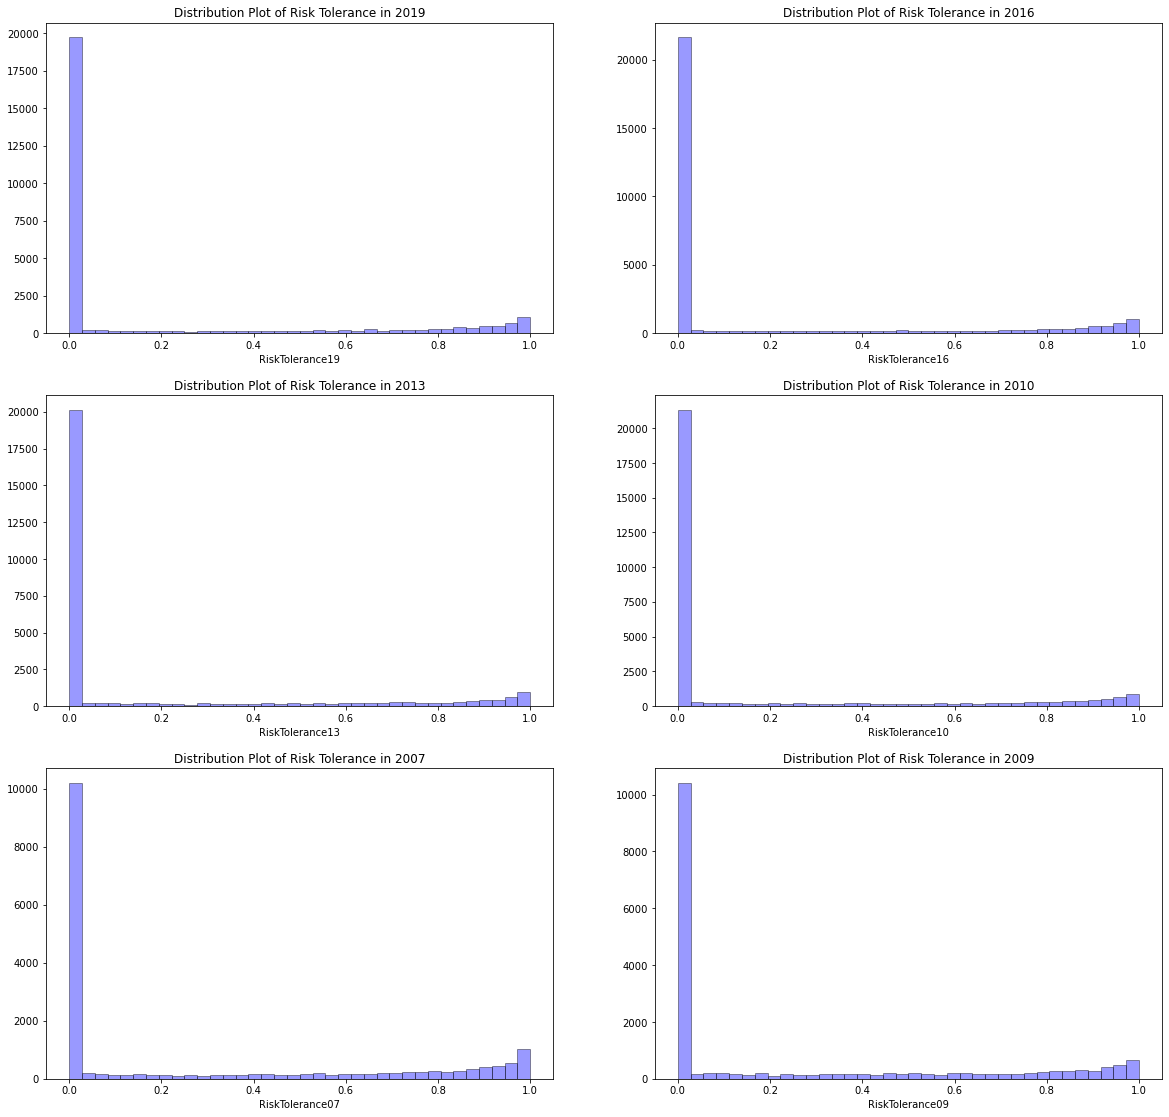

In [81]:
plt.figure(figsize=(20, 40))

plt.subplot(6, 2, 1)
# Looking at the Distribution Plot that include Risk Tolerance < 1.0
sns.distplot(data19['RiskTolerance19'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Distribution Plot of Risk Tolerance in 2019')

plt.subplot(6, 2, 2)
# Looking at the Distribution Plot that include Risk Tolerance < 1.0
sns.distplot(data16['RiskTolerance16'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Distribution Plot of Risk Tolerance in 2016')

plt.subplot(6, 2, 3)
# Looking at the Distribution Plot that include Risk Tolerance < 1.0
sns.distplot(data13['RiskTolerance13'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Distribution Plot of Risk Tolerance in 2013')

plt.subplot(6, 2, 4)
# Looking at the Distribution Plot that include Risk Tolerance < 1.0
sns.distplot(data10['RiskTolerance10'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Distribution Plot of Risk Tolerance in 2010')

plt.subplot(6, 2, 5)
# Looking at the Distribution Plot that include Risk Tolerance < 1.0
sns.distplot(data09['RiskTolerance07'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Distribution Plot of Risk Tolerance in 2007')

plt.subplot(6, 2, 6)
sns.distplot(data09['RiskTolerance09'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Distribution Plot of Risk Tolerance in 2009')

- We see quite a lot of 0 Risk Tolerances due to many entries of households that contain no Bonds, Stocks, Real Estate, etc. Removing this data can help us get a better idea on what the distribution of Risk Tolerance looks like in the years
- There is a lot of data skewed to 0 Risk Tolerance so we will remove them in order to address the imbalance and have a more pertinent distribution reflective of Risk Tolerance

### Distribution Plot that include Risk Tolerance > 0

In [82]:
# Only considering Risk Tolerance thats more than 0
data19 = data19.loc[~(data19['RiskTolerance19'] == 0)]
data16 = data16.loc[~(data16['RiskTolerance16'] == 0)]
data13 = data13.loc[~(data13['RiskTolerance13'] == 0)]
data10 = data10.loc[~(data10['RiskTolerance10'] == 0)]
data09 = data09.loc[~(data09['RiskTolerance07'] == 0)]
data09 = data09.loc[~(data09['RiskTolerance09'] == 0)]

Text(0.5, 1.0, 'Distribution Plot of Risk Tolerance in 2009')

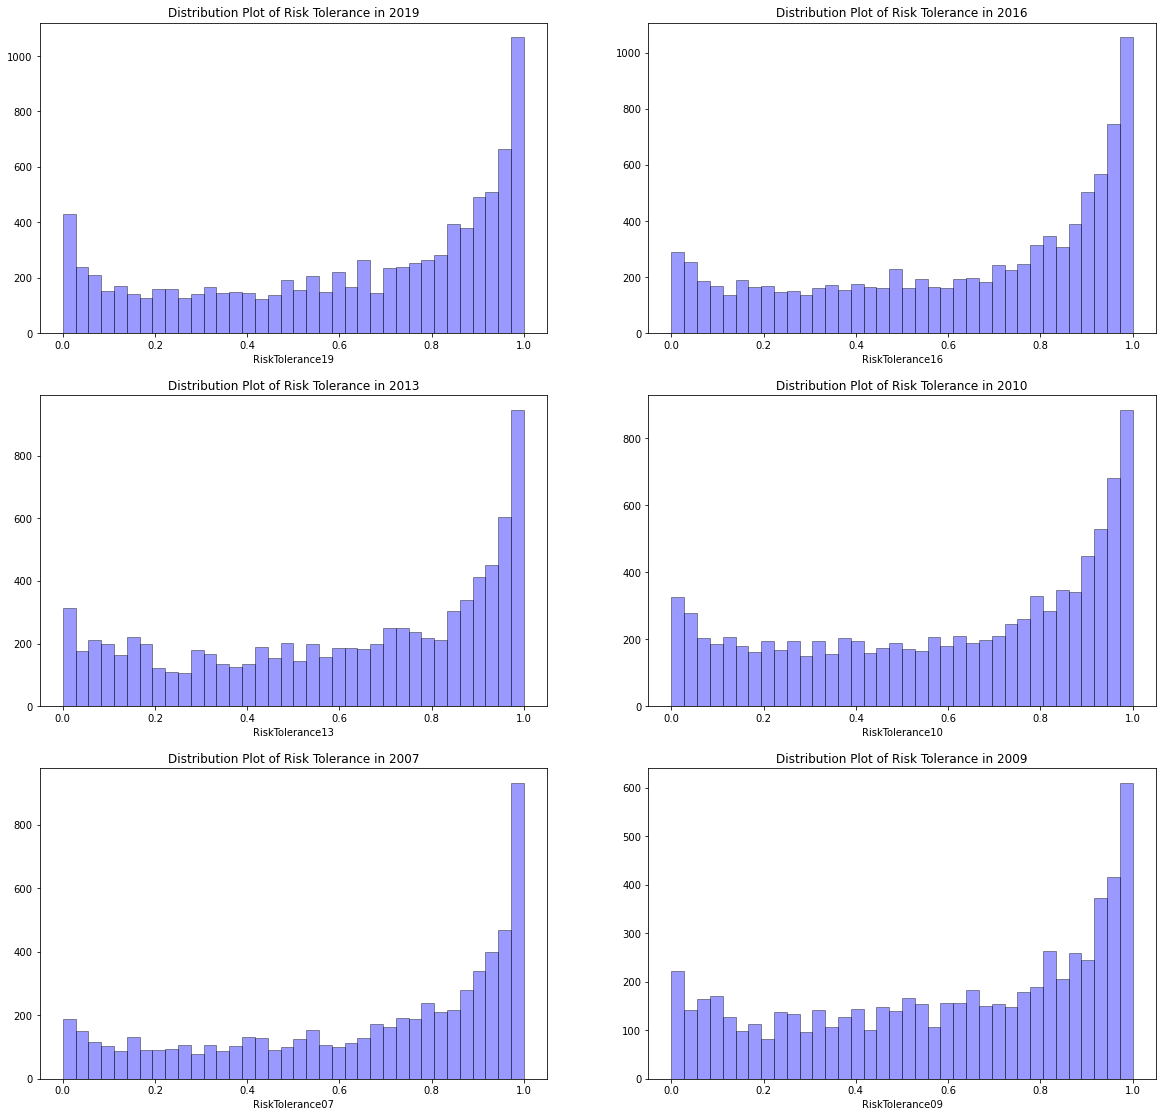

In [83]:
plt.figure(figsize=(20, 40))

plt.subplot(6, 2, 1)
# Looking at the Distribution Plot that include Risk Tolerance < 1.0
sns.distplot(data19['RiskTolerance19'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Distribution Plot of Risk Tolerance in 2019')

plt.subplot(6, 2, 2)
# Looking at the Distribution Plot that include Risk Tolerance < 1.0
sns.distplot(data16['RiskTolerance16'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Distribution Plot of Risk Tolerance in 2016')

plt.subplot(6, 2, 3)
# Looking at the Distribution Plot that include Risk Tolerance < 1.0
sns.distplot(data13['RiskTolerance13'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Distribution Plot of Risk Tolerance in 2013')

plt.subplot(6, 2, 4)
# Looking at the Distribution Plot that include Risk Tolerance < 1.0
sns.distplot(data10['RiskTolerance10'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Distribution Plot of Risk Tolerance in 2010')

plt.subplot(6, 2, 5)
# Looking at the Distribution Plot that include Risk Tolerance < 1.0
sns.distplot(data09['RiskTolerance07'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Distribution Plot of Risk Tolerance in 2007')

plt.subplot(6, 2, 6)
sns.distplot(data09['RiskTolerance09'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Distribution Plot of Risk Tolerance in 2009')

- We can see when comparing between Risk Tolerance in 2007 and 2009, more households skew more to having less Risk Tolerance in 2009 than in 2007. The impact of the 2008 crisis had a clear effect on households to become more risk averse

Text(0.5, 1.0, 'Distribution Plot of Risk Tolerance average in 2007 and 2009')

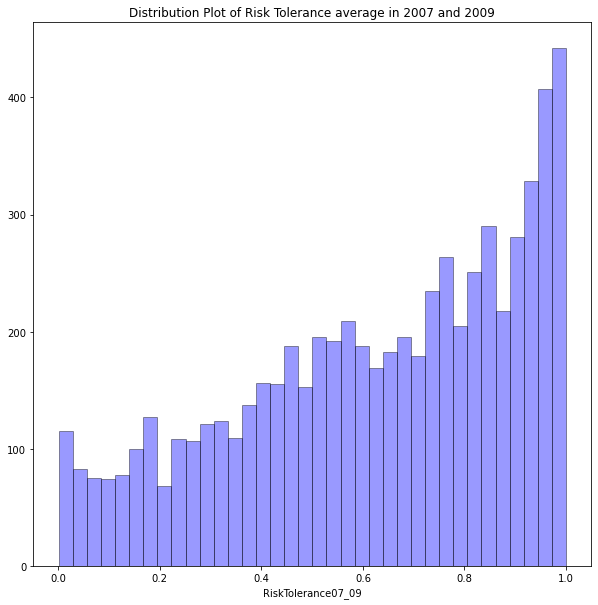

In [84]:
plt.figure(figsize=(10, 10))
sns.distplot(data09['RiskTolerance07_09'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Distribution Plot of Risk Tolerance average in 2007 and 2009')

# Feature Selection and Engineering

**Criteria for Feature Selection:**  
1. Since the purpose is to use features that are intuitive and readily available to the average investor, we will focus on simpler features. If we ask the investor to provide some data which is esoteric and difficult to obtain like asking about which Alternate Normal income percentile group they belong to or asking the investor to provide total monthly consumer debt payments or features of that nature
2. Features that are most overtly determinant of risk tolerance (Age, Financial Standing, Financial Dependants, Time Horizon, etc.) through correlation and feature exploration
3. We will **not** include elements related to race, religion, sex, etc. due to ethical implications

### Top 10 Features Correlated with Risk Tolerance

In [85]:
data19.corr().nlargest(12, 'RiskTolerance19')['RiskTolerance19'].index

Index(['RiskTolerance19', 'HNMMF', 'NWPCTLECAT', 'NWCAT', 'ASSETCAT', 'AGE',
       'AGECL', 'NINCPCTLECAT', 'NSTOCKS', 'INCPCTLECAT', 'NINC2CAT', 'HBROK'],
      dtype='object')

- Ignoring RiskTolerance19 and HNMMF, lets explore the correlation of the other features listed above

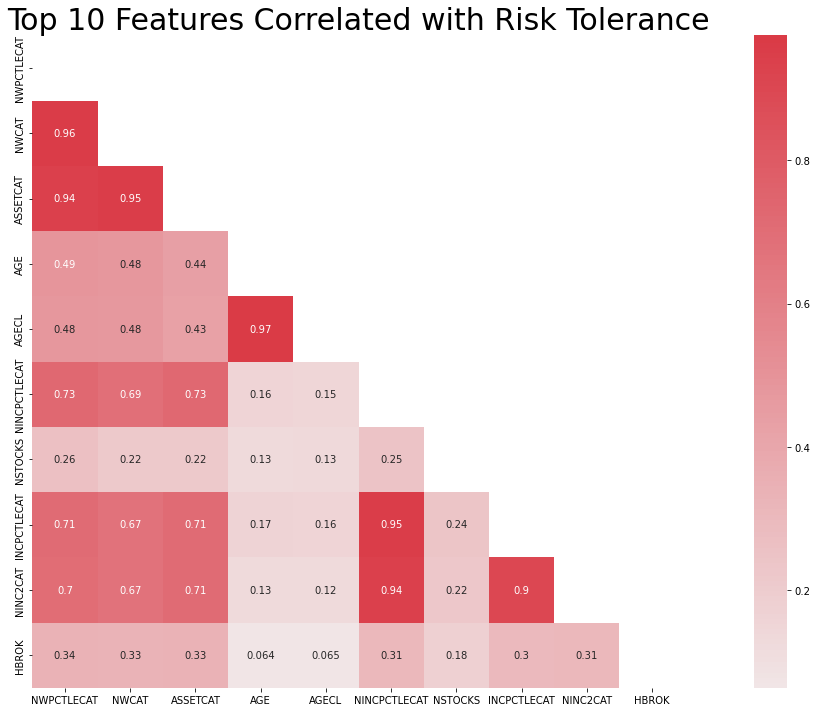

In [86]:
# Diagonal Heatmap using correlated features found above

fig, ax = plt.subplots(figsize = (25,12))

mask = np.zeros_like(data19[['NWPCTLECAT', 'NWCAT', 'ASSETCAT', 'AGE',
       'AGECL', 'NINCPCTLECAT', 'NSTOCKS', 'INCPCTLECAT', 'NINC2CAT', 'HBROK']].corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(data19[['NWPCTLECAT', 'NWCAT', 'ASSETCAT', 'AGE',
       'AGECL', 'NINCPCTLECAT', 'NSTOCKS', 'INCPCTLECAT', 'NINC2CAT', 'HBROK']].corr(), mask=mask, annot=True, center = 0, cmap = sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)
ax.tick_params(labelsize=10)
plt.title('Top 10 Features Correlated with Risk Tolerance', fontsize=30);

**The Top 10 Features Correlated with Risk Tolerance**
Just from precursory analysis
- Alternate net worth percentile groups (NWPCTLECAT)
- Net worth percentile groups (NWCAT)
- Asset percentile groups (ASSETCAT)
- Age of reference person (AGE)
- Age group of the reference person (AGECL)
- Alternate Normal income percentile groups (NINCPCTLECAT)
- Number different companies in which hold stock (NSTOCKS)
- Alternate income percentile groups (INCPCTLECAT)
- Normal income percentile groups (NINC2CAT)
- Have a brokerage account (HBROK)

**Problems with these features despite high correlation**
1. We can see a high degree of multicollinearity amongst certain features (For example, AGE and AGECL)
2. A lot of the features involve data or information that is not easily or readily accessible to the average person. This would not be acceptable as the aim is to focus on simpler features to reduce manual input time of data to retrieving a Risk Tolerance prediction

**Solution to this problem going forward**
1. Regarding multicollinearity, we will select the simplest and most relevant feature amongst them
2. To select the features that are more readily available the investor like their age or whether or not they have a brokerage account
3. We will use data visualisation and exploration techniques to analyse each feature in detail before proceeding

# Feature Exploration and Data Visualisation

**Feature Exploration and Candidacy for Selection**  
- **AGE**: This is an important feature and will be kept. 
Age groups are:   
1.  <35      4.  55-64  
2.  35-44   5.  65-74  
3.  45-54   6.  >=75  
There are 2 age features, Age and Age group we will just go with AGE itself  

- **EDUC** and **EDCL** (Education): Highest completed grade by reference person and Education category of reference person
- **MARRIED** : Marital status of reference person
- **KIDS** : Total number of children in household
- **OCCAT1** and **OCCAT2**: 	Occupation categories/ Classifications for reference person
- **NETWORTH** and **NWCAT**: Total net worth of household/Net worth percentile groups
- **INCOME**: Total amount of income of household
- **WAGEINC**: Wage and salary income
- **NOFINRISK** and **YSEFINRISK**: Willingness to take risk - Respondent not willing to take financial risk and/or Respondent willing to take financial risk
- **SAVING**: Total value of savings accounts held by household
- **HSTOCKS** : Do you have stocks?
- **HBROK** : Do you have a brokerage account?
- **HOUSECL** : Home-ownership category of household

## Age

Text(0.5, 1.0, 'Age by Risk Tolerance in 2019')

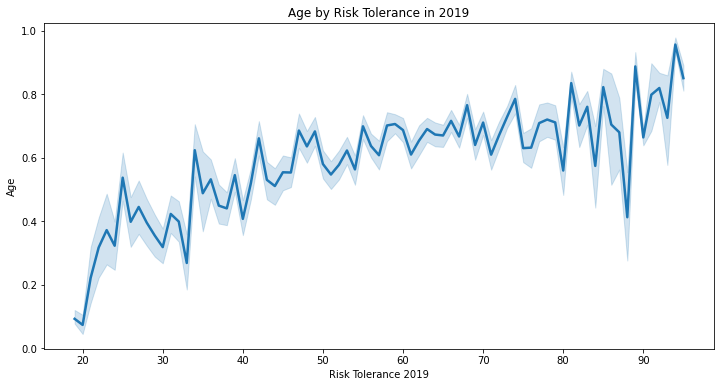

In [87]:
# Lineplot for Age by Risk Tolerance in 2019 dataset
plt.figure(figsize=(12,6))
sns.lineplot(x="AGE", y="RiskTolerance19",
            linewidth=2.5,
             data=data19)
plt.xlabel('Risk Tolerance 2019')
plt.ylabel('Age')
plt.title('Age by Risk Tolerance in 2019')

- We can see generally Risk Tolerance increases with age
- This is inlign with other studies conducted to analyse this issue, please find link below
https://www.researchgate.net/publication/228980285_Does_Risk_Tolerance_Decrease_With_Age

## Education

- EDUC is the highest completed grade by reference group (15 categories from less than 1st grade to Doctorate)
- EDCL is the education catregory of the reference person (4 categories from no high school diploma to college degree)

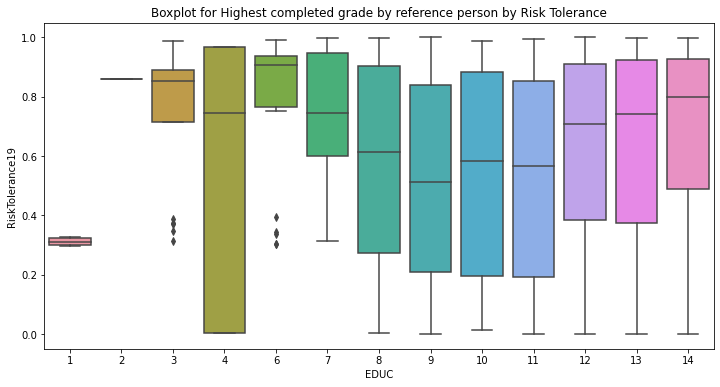

In [88]:
# Boxplot for Highest completed grade by reference person by Risk Tolerance
plt.figure(figsize=(12,6))
sns.boxplot(x="EDUC", y="RiskTolerance19",data=data19)
plt.title("Boxplot for Highest completed grade by reference person by Risk Tolerance",fontsize=12);

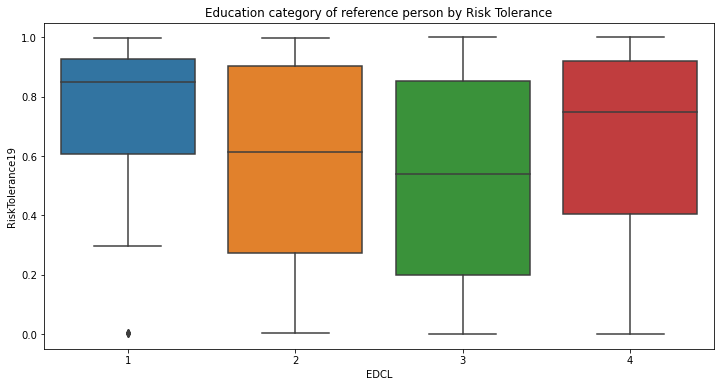

In [89]:
# Boxplot for Education category of reference person by Risk Tolerance
plt.figure(figsize=(12,6))
sns.boxplot(x="EDCL", y="RiskTolerance19",data=data19)
plt.title("Education category of reference person by Risk Tolerance",fontsize=12);

- Interestingly we see higher Risk Tolerances for households with both low and high educational attainment but relatively dipped lower levels for Educational levels in-between

## Marital Status

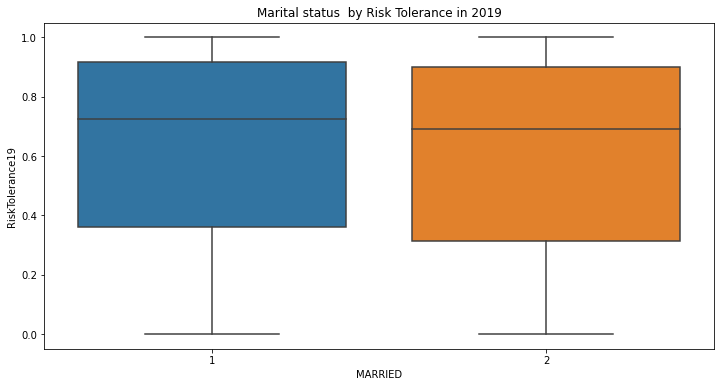

In [90]:
# Boxplot for Marital status  by Risk Tolerance in 2019
plt.figure(figsize=(12,6))
sns.boxplot(x="MARRIED", y="RiskTolerance19",data=data19)
plt.title("Marital status  by Risk Tolerance in 2019",fontsize=12);

- 1 refers to married/living with partner and 2 refers to neither married nor living with partner
- Seems like there is little difference between the marital status and risk tolerance

## Number of Children 

Text(0.5, 1.0, 'Total number of children in household by Risk Tolerance in 2019')

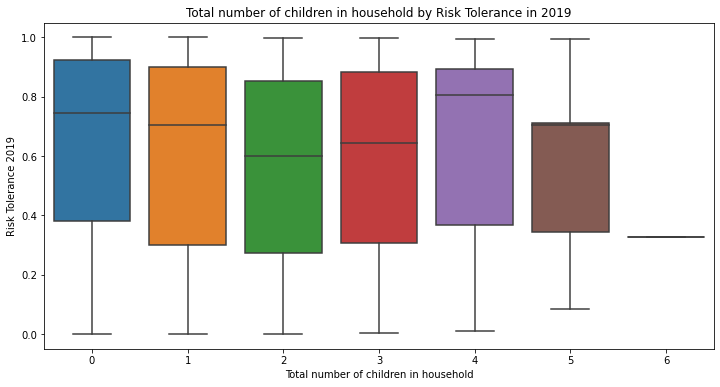

In [91]:
# Boxplot for Number of Children by Risk Tolerance in 2019
plt.figure(figsize=(12,6))
sns.boxplot(x="KIDS", y="RiskTolerance19",data=data19)
plt.xlabel('Total number of children in household')
plt.ylabel('Risk Tolerance 2019')
plt.title('Total number of children in household by Risk Tolerance in 2019')

- Generally there seems to be a downward trend between having more children and Risk Tolerance

## Occupation

Text(0.5, 1.0, 'Occupation categories for reference person by Risk Tolerance in 2019')

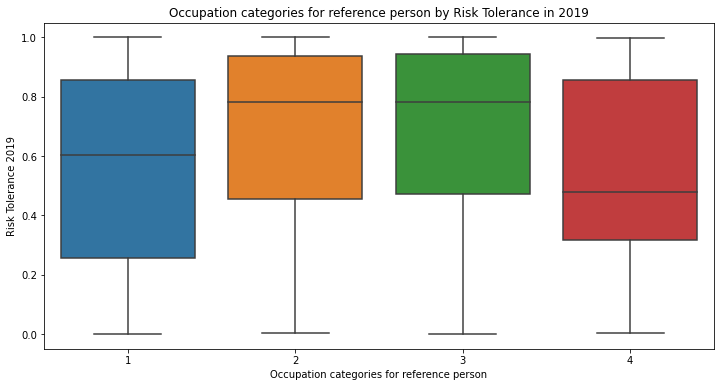

In [92]:
# Boxplot for Occupation Categories by Risk Tolerance in 2019
plt.figure(figsize=(12,6))
sns.boxplot(x="OCCAT1", y="RiskTolerance19",data=data19)
plt.xlabel('Occupation categories for reference person')
plt.ylabel('Risk Tolerance 2019')
plt.title('Occupation categories for reference person by Risk Tolerance in 2019')

1. work for someone else 
2. self-employed/partnership
3. retired/disabled + (student/homemaker/misc. not working and age 65 or older)
4. other groups not working (mainly those under 65 and out of the labor force)

- Seems like generally self-employed and retired individuals have higher risk tolerances

Text(0.5, 1.0, 'Occupation classification for reference person by Risk Tolerance in 2019')

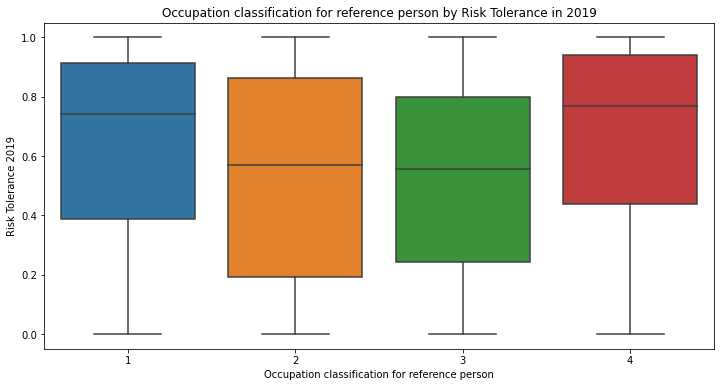

In [93]:
# Boxplot for Occupation Categories by Risk Tolerance in 2019
plt.figure(figsize=(12,6))
sns.boxplot(x="OCCAT2", y="RiskTolerance19",data=data19)
plt.xlabel('Occupation classification for reference person')
plt.ylabel('Risk Tolerance 2019')
plt.title('Occupation classification for reference person by Risk Tolerance in 2019')

1. managerial/professional 
2. technical/sales/services
3. other (incl. production/craft/repair workers, operators, laborers, 
  farmers, foresters, fishers) 
4. not working

- The boxplot above shows higher risk tolerances for professionals and managers as well as those not working (which could be retired individuals)

## Net Worth

Text(0.5, 1.0, 'Total net worth of household by Risk Tolerance in 2019')

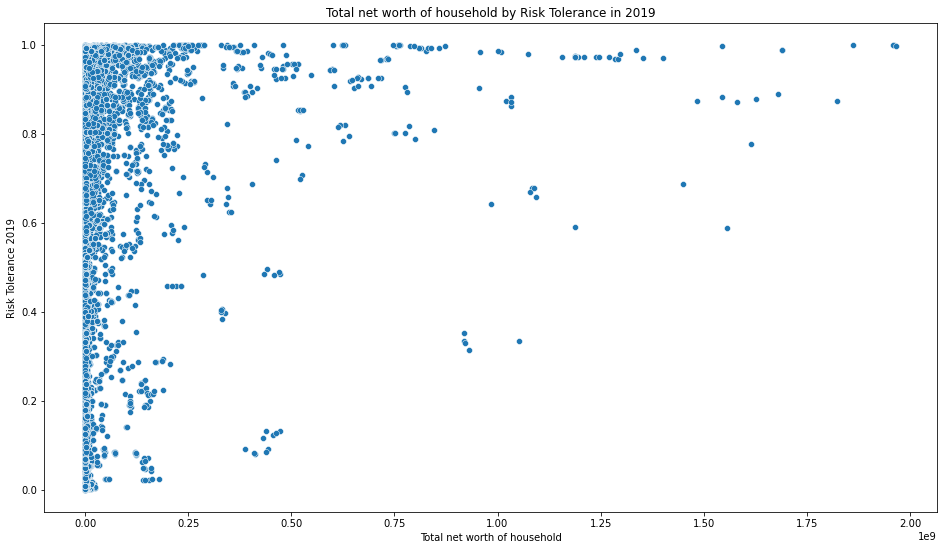

In [94]:
# Scatterplot for Net Worth by Risk Tolerance in 2019
plt.figure(figsize=(16,9))
sns.scatterplot(x="NETWORTH",y="RiskTolerance19",data=data19)
plt.xlabel('Total net worth of household')
plt.ylabel('Risk Tolerance 2019')
plt.title('Total net worth of household by Risk Tolerance in 2019')

- Hard to identify a specific trend from the scatterplot above, but generally higher risk tolerances are associated with higher total net worth

Text(0.5, 1.0, 'Net worth percentile groups by Risk Tolerance in 2019')

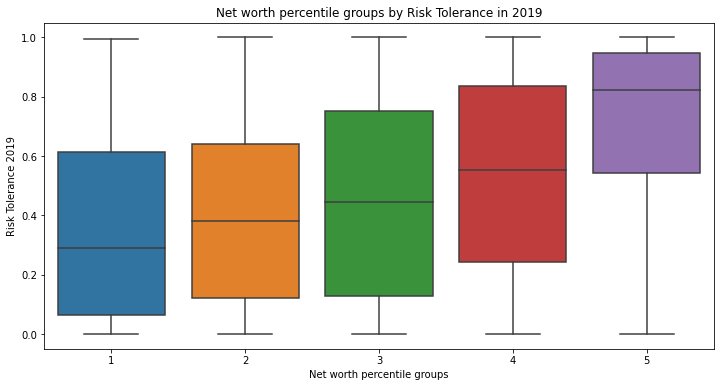

In [95]:
# Boxplot for Net worth percentile groups by Risk Tolerance in 2019
plt.figure(figsize=(12,6))
sns.boxplot(x="NWCAT", y="RiskTolerance19",data=data19)
plt.xlabel('Net worth percentile groups')
plt.ylabel('Risk Tolerance 2019')
plt.title('Net worth percentile groups by Risk Tolerance in 2019')

- Here we can clearly see the higher Net worth percentile groups have higher Risk Tolerances

## Wage and salary income

Text(0.5, 1.0, 'Wage and salary income by Risk Tolerance in 2019')

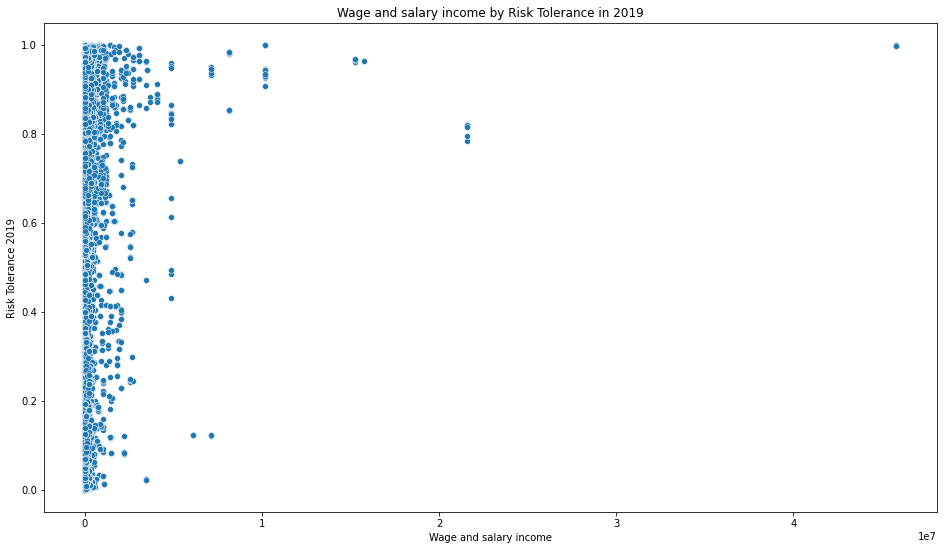

In [96]:
# Scatterplot for Wage and salary income, by Risk Tolerance in 2019
plt.figure(figsize=(16,9))
sns.scatterplot(x="WAGEINC",y="RiskTolerance19",data=data19)
plt.xlabel('Wage and salary income')
plt.ylabel('Risk Tolerance 2019')
plt.title('Wage and salary income by Risk Tolerance in 2019')

- Slight trend between increased wage/salary income and Risk Tolerance

## Willingness to Take Risk

Text(0.5, 1.0, 'Not willing to take financial risk by Risk Tolerance in 2019')

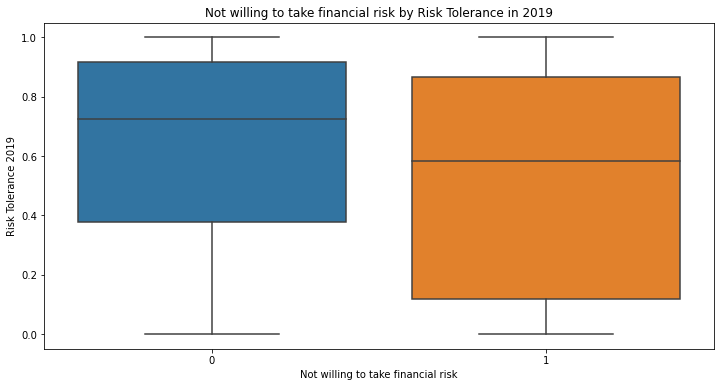

In [97]:
# Boxplot for Respondent not willing to take financial risk by Risk Tolerance in 2019
plt.figure(figsize=(12,6))
sns.boxplot(x="NOFINRISK", y="RiskTolerance19",data=data19)
plt.xlabel('Not willing to take financial risk')
plt.ylabel('Risk Tolerance 2019')
plt.title('Not willing to take financial risk by Risk Tolerance in 2019')

- 0 means the respondent is willing to take Financial Risk 
- 1 means the respondent is NOT willing to take Financial Risk 

- We can see lower risk tolerance with households not willing to take financial risk

Text(0.5, 1.0, 'Willing to take financial risk by Risk Tolerance in 2019')

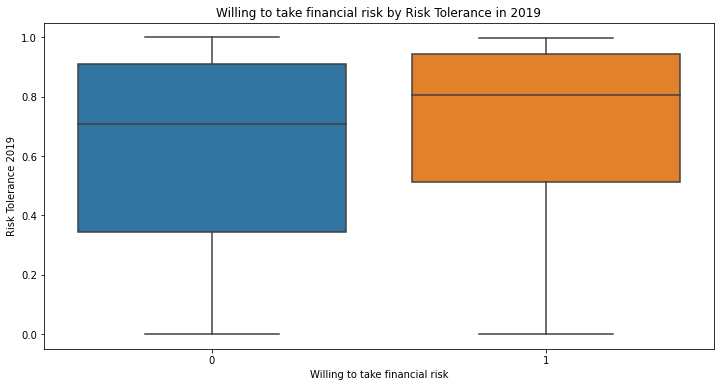

In [98]:
# Boxplot for Respondent willing to take financial risk by Risk Tolerance in 2019
plt.figure(figsize=(12,6))
sns.boxplot(x="YESFINRISK", y="RiskTolerance19",data=data19)
plt.xlabel('Willing to take financial risk')
plt.ylabel('Risk Tolerance 2019')
plt.title('Willing to take financial risk by Risk Tolerance in 2019')

- 0 means the respondent is NOT willing to take Financial Risk 
- 1 means the respondent is willing to take Financial Risk 

- We can see higher risk tolerance with households willing to take financial risk

## Savings

Text(0.5, 1.0, 'Total value of savings accounts held by household by Risk Tolerance in 2019')

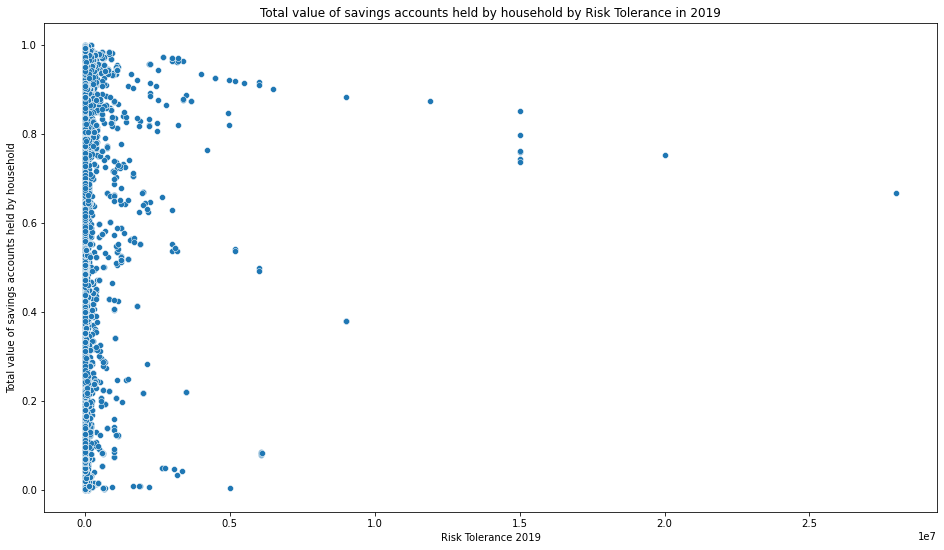

In [99]:
plt.figure(figsize=(16,9))
sns.scatterplot(x="SAVING",y="RiskTolerance19",data=data19)
plt.xlabel('Risk Tolerance 2019')
plt.ylabel('Total value of savings accounts held by household')
plt.title('Total value of savings accounts held by household by Risk Tolerance in 2019')

- Hard to analyse any distinct trend between Savings and Risk Tolerance from the scatterplot above

## Has Stock

Text(0.5, 1.0, 'Have Stocks by Risk Tolerance')

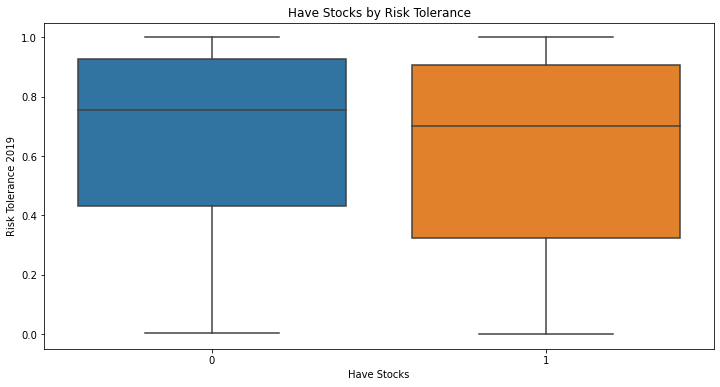

In [100]:
# Boxplot for Having Stocks by Risk Tolerance in 2019
plt.figure(figsize=(12,6))
sns.boxplot(x="HSTOCKS", y="RiskTolerance19",data=data19)
plt.xlabel('Have Stocks')
plt.ylabel('Risk Tolerance 2019')
plt.title('Have Stocks by Risk Tolerance')

0	no  
1	yes
- The Risk Tolerance seems to be similar

## Has Brokerage Account

Text(0.5, 1.0, 'Has Brokerage Account by Risk Tolerance')

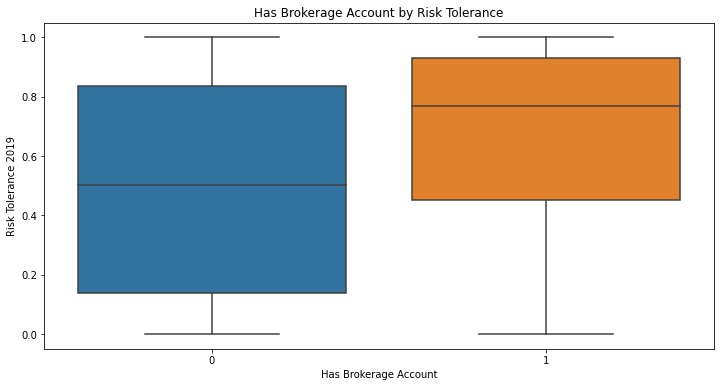

In [101]:
# Boxplot for Has Brokerage Account by Risk Tolerance in 2019
plt.figure(figsize=(12,6))
sns.boxplot(x="HBROK", y="RiskTolerance19",data=data19)
plt.xlabel('Has Brokerage Account')
plt.ylabel('Risk Tolerance 2019')
plt.title('Has Brokerage Account by Risk Tolerance')

0	no  
1	yes
- The Risk Tolerance is higher if they have a brokerage account

## Home Ownership

Text(0.5, 1.0, 'Home-ownership category of household by Risk Tolerance')

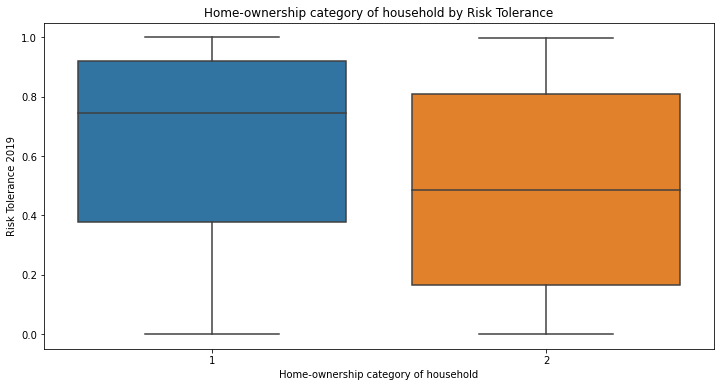

In [102]:
# Boxplot for Home-ownership category of household by Risk Tolerance

plt.figure(figsize=(12,6))
sns.boxplot(x="HOUSECL", y="RiskTolerance19",data=data19)
plt.xlabel('Home-ownership category of household')
plt.ylabel('Risk Tolerance 2019')
plt.title('Home-ownership category of household by Risk Tolerance')

1=owns ranch/farm/mobile home/house/condo/coop/etc.,   
2=otherwise

- Non ownership is associated with lower Risk Tolerance

## Summary of findings from Feature Exploration
| Feature                  | General Trend in relation to Risk Tolerance from EDA                                |
| ------------------------ | ----------------------------------------------------------------------------------- |
| Age                      | Generally Risk Tolerance increases with age<br>                                     |
| Education                | Higher Risk Tolerances for households with both low and high educational attainment |
| Marital Status           | Little difference between the marital status and risk tolerance                     |
| Number of Children       | Downward trend between having more children and risk tolerance                      |
| Occupation               | Generally self-employed and retired individuals have higher risk tolerances         |
| Net Worth                | Higher Net worth percentile groups have higher Risk Tolerances                      |
| Wage and salary income   | Slight trend between increased wage/salary income and Risk Tolerance                |
| Willingness to Take Risk | Higher risk tolerance with households willing to take financial risk                |
| Savings                  | Slight trend between increased Savings and Risk Tolerance                           |
| Has Stock                | Risk Tolerance seems to be similar                                                  |
| Has Brokerage Account    | Risk Tolerance is higher if they have a brokerage account                           |
| Home Ownership           | Non home ownership is associated with lower Risk Tolerance                          |



## Feature Selection for 2019, 2016, 2013, 2010, 2009 and 2007

**Taking the above features analysed and incorporating the criteria for selection, the following features have been selected for incorporation into modelling:**  
1. Age
2. Education/Education Category
3. Marital Status
4. Number of Children
5. Occupation Category/Classification
6. Networth/Networth Percentile Groups
7. Income/Wage and Salary Income
8. Willingness to take risk
9. Savings 
10. Whether or not the individual has stocks
11. Whether or not the individual has a brokerage account
12. Home-ownership category of household

In [103]:
# Feature Selection 2019
keep_list19 = ['AGE', 'EDUC','EDCL', 'MARRIED','KIDS','OCCAT1','OCCAT2', 'NETWORTH', 'NWCAT', 'INCOME', 'WAGEINC',
               'YESFINRISK', 'NOFINRISK','SAVING', 'HSTOCKS', 'HBROK', 'HOUSECL', 'RiskTolerance19']

drop_list19 = [col for col in data19.columns if col not in keep_list19]

data19.drop(labels=drop_list19, axis=1, inplace=True)

# Feature Selection 2016
keep_list16 = ['AGE', 'EDUC','EDCL', 'MARRIED','KIDS','OCCAT1','OCCAT2', 'NETWORTH', 'NWCAT', 'INCOME', 'WAGEINC',
               'YESFINRISK', 'NOFINRISK','SAVING', 'HSTOCKS', 'HBROK', 'HOUSECL', 'RiskTolerance16']

drop_list16 = [col for col in data16.columns if col not in keep_list16]

data16.drop(labels=drop_list16, axis=1, inplace=True)

# Feature Selection 2013
keep_list13 = ['AGE', 'EDUC','EDCL', 'MARRIED','KIDS','OCCAT1','OCCAT2', 'NETWORTH', 'NWCAT', 'INCOME', 'WAGEINC',
               'YESFINRISK', 'NOFINRISK','SAVING', 'HSTOCKS', 'HBROK', 'HOUSECL', 'RiskTolerance13']

drop_list13 = [col for col in data13.columns if col not in keep_list13]

data13.drop(labels=drop_list13, axis=1, inplace=True)

# Feature Selection 2010
keep_list10 = ['AGE', 'EDUC','EDCL', 'MARRIED','KIDS','OCCAT1','OCCAT2', 'NETWORTH', 'NWCAT', 'INCOME', 'WAGEINC',
               'YESFINRISK', 'NOFINRISK','SAVING', 'HSTOCKS', 'HBROK', 'HOUSECL', 'RiskTolerance10']

drop_list10 = [col for col in data10.columns if col not in keep_list10]

data10.drop(labels=drop_list10, axis=1, inplace=True)

# Feature Selection 2009 and 2007
keep_list09 = ['AGE09','EDCL09','MARRIED09','KIDS09','OCCAT109','INCOME09','RISK09','NETWORTH09','RiskTolerance09', 'AGE07','EDCL07','MARRIED07','KIDS07','OCCAT107','INCOME07','RISK07','NETWORTH07','RiskTolerance07']

drop_list09 = [col for col in data09.columns if col not in keep_list09]

data09.drop(labels=drop_list09, axis=1, inplace=True)

## Correlation Heatmap between Selected Features and Risk Tolerance for 2019

Text(0.5, 1.0, 'Correlation Matrix of Selected Features')

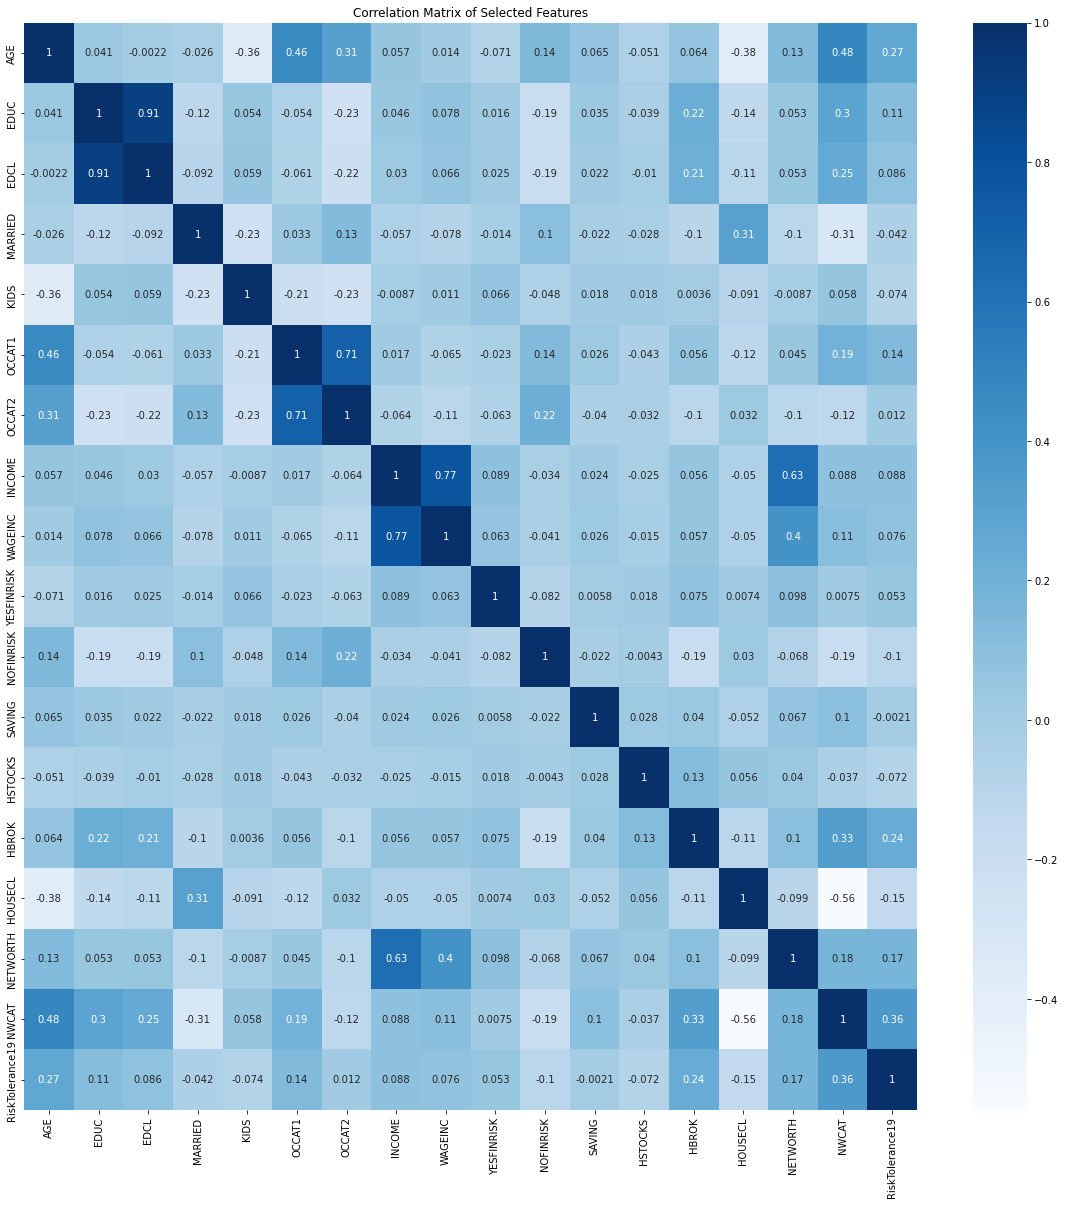

In [104]:
## General view on correlation

f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(data19.corr(),cmap='Blues',annot=True)
plt.title('Correlation Matrix of Selected Features')

<Figure size 864x864 with 0 Axes>

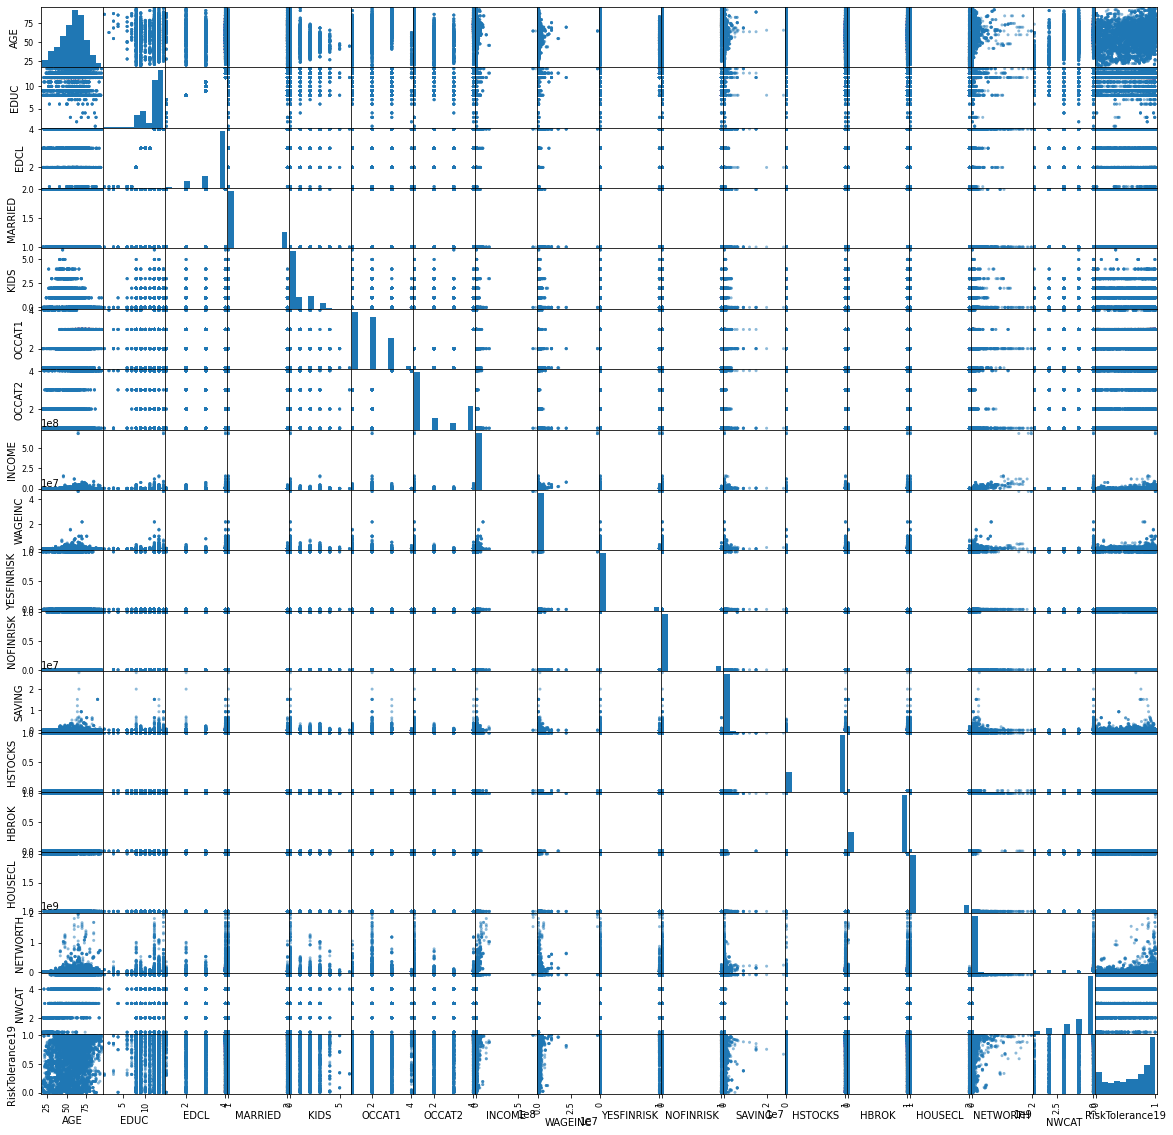

In [105]:
# Scatterplot Matrix
from pandas.plotting import scatter_matrix
plt.figure(figsize=(12,12))
scatter_matrix(data19,figsize=(20,20))
plt.show()

## Comparison of Selected Features Correlated with Risk Tolerance for different Years

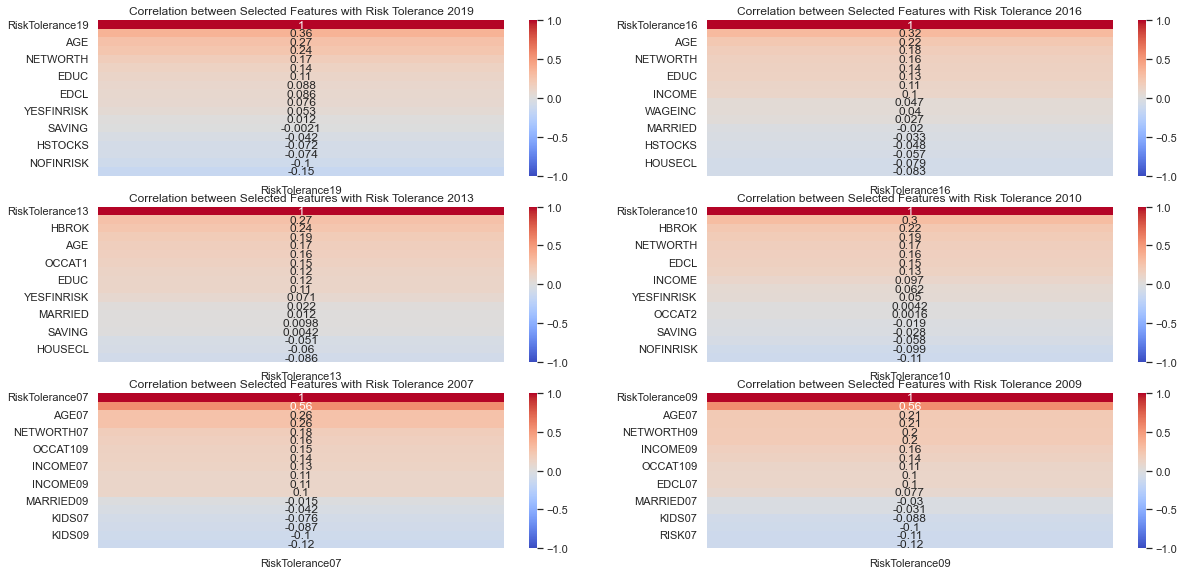

In [106]:
correlation19 = data19.corr()
correlation16 = data16.corr()
correlation13 = data13.corr()
correlation10 = data10.corr()
correlation09 = data09.corr()

plt.figure(figsize=(20,20))
sns.set(font_scale=1)

plt.subplot(6, 2, 1)
sns.heatmap(correlation19[['RiskTolerance19']].sort_values(by=['RiskTolerance19'], ascending=False),
            vmin=-1,
            cmap='coolwarm',
            annot=True)
plt.title('Correlation between Selected Features with Risk Tolerance 2019');


plt.subplot(6, 2, 2)
sns.heatmap(correlation16[['RiskTolerance16']].sort_values(by=['RiskTolerance16'], ascending=False),
            vmin=-1,
            cmap='coolwarm',
            annot=True)
plt.title('Correlation between Selected Features with Risk Tolerance 2016');

plt.subplot(6, 2, 3)
sns.heatmap(correlation13[['RiskTolerance13']].sort_values(by=['RiskTolerance13'], ascending=False),
            vmin=-1,
            cmap='coolwarm',
            annot=True)
plt.title('Correlation between Selected Features with Risk Tolerance 2013');

plt.subplot(6, 2, 4)
sns.heatmap(correlation10[['RiskTolerance10']].sort_values(by=['RiskTolerance10'], ascending=False),
            vmin=-1,
            cmap='coolwarm',
            annot=True)
plt.title('Correlation between Selected Features with Risk Tolerance 2010');

plt.subplot(6, 2, 5)
sns.heatmap(correlation09[['RiskTolerance07']].sort_values(by=['RiskTolerance07'], ascending=False),
            vmin=-1,
            cmap='coolwarm',
            annot=True)
plt.title('Correlation between Selected Features with Risk Tolerance 2007');

plt.subplot(6, 2, 6)
sns.heatmap(correlation09[['RiskTolerance09']].sort_values(by=['RiskTolerance09'], ascending=False),
            vmin=-1,
            cmap='coolwarm',
            annot=True)
plt.title('Correlation between Selected Features with Risk Tolerance 2009');

## Merging the dataset years of 2019, 2016, 2013 and 2010

- Please note we are not using 2009 and 2007 because there are certain important selected features like Willingness to take risk which are absent in the dataset

In [107]:
# Renaming Risk Tolerance in order
data19 = data19.rename(columns={"RiskTolerance19": "RiskTolerance"})
data16 = data16.rename(columns={"RiskTolerance16": "RiskTolerance"})
data13 = data13.rename(columns={"RiskTolerance13": "RiskTolerance"})
data10 = data10.rename(columns={"RiskTolerance10": "RiskTolerance"})

In [108]:
# Concat the datasets of different years into a single dataset
dataset = pd.concat([data19, data16, data13, data10])

In [109]:
# Combined Dataset shape
dataset.shape

(36545, 18)

In [110]:
# Checking for null values in combined dataset
dataset.isnull().sum().sort_values(ascending=False).reset_index()

,index,0
0,AGE,0
1,EDUC,0
2,NWCAT,0
3,NETWORTH,0
4,HOUSECL,0
5,HBROK,0
6,HSTOCKS,0
7,SAVING,0
8,NOFINRISK,0
9,YESFINRISK,0


In [111]:
# Taking a look at the combined dataset
dataset.head()

,AGE,EDUC,EDCL,MARRIED,KIDS,OCCAT1,OCCAT2,INCOME,WAGEINC,YESFINRISK,NOFINRISK,SAVING,HSTOCKS,HBROK,HOUSECL,NETWORTH,NWCAT,RiskTolerance
0,75,12.0,4,2,0,1,1,67195.781504,1018.117902,0,0,0.0,0,1,1,2153600.0,5,0.842437
1,75,12.0,4,2,0,1,1,57014.602488,1018.117902,0,0,0.0,0,1,1,2116200.0,5,0.823661
2,75,12.0,4,2,0,1,1,51924.012980,1018.117902,0,0,0.0,0,1,1,2145000.0,5,0.834728
3,75,12.0,4,2,0,1,1,41742.833964,1018.117902,0,0,0.0,0,1,1,2552500.0,5,0.911162
4,75,12.0,4,2,0,1,1,50905.895078,1018.117902,0,0,0.0,0,1,1,2176200.0,5,0.844758


In [112]:
dataset.tail()

,AGE,EDUC,EDCL,MARRIED,KIDS,OCCAT1,OCCAT2,INCOME,WAGEINC,YESFINRISK,NOFINRISK,SAVING,HSTOCKS,HBROK,HOUSECL,NETWORTH,NWCAT,RiskTolerance
32380,42,13.0,4,1,2,2,1,3.293639e+06,71861.207296,0,0,24271.922717,0,1,1,3.500058e+07,5,0.988045
32381,42,13.0,4,1,2,2,1,3.293639e+06,71861.207296,0,0,24271.922717,0,1,1,3.500058e+07,5,0.988045
32382,42,13.0,4,1,2,2,1,3.293639e+06,71861.207296,0,0,24271.922717,0,1,1,3.500058e+07,5,0.988045
32383,42,13.0,4,1,2,2,1,3.293639e+06,71861.207296,0,0,24271.922717,0,1,1,3.500058e+07,5,0.988045
32384,42,13.0,4,1,2,2,1,3.293639e+06,71861.207296,0,0,24271.922717,0,1,1,3.500058e+07,5,0.988045


In [113]:
dataset.shape

(36545, 18)

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='RiskTolerance'>

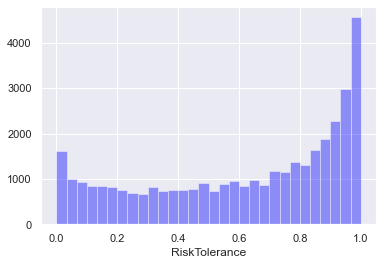

In [114]:
# Distribution of Risk Tolerance for Final Dataset
sns.distplot(dataset['RiskTolerance'], kde = False, color ='blue', bins = 30)

# Train Test Split

### Assemble our predictor variables (X) and our target (y) 

- We start by splitting our dataset into training and testing data

In [115]:
X = dataset.drop('RiskTolerance',axis=1)
y = dataset['RiskTolerance']

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


mu = 0.62, sigma = 0.32, skew = -0.4961022547705563


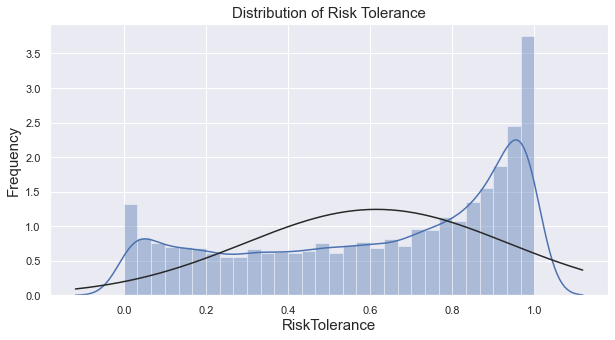

In [116]:
# Taking a look at the distribution plot for Risk Tolerance in the combined dataset
distribution_plot(y)

In [117]:
validation_size = 0.25
seed = 42
# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=validation_size, random_state=seed)

# Addressing Multicollinearity

- Variance Inflation Factor (VIF) is a measure of the amount of multicollinearity in regression analysis
- Multicollinearity exists when there is a correlation between multiple independent variables in a multiple regression model, which adversly affects the results

### Variance Inflation Factor (VIF)

In [118]:
VIF(X_train)

,feature,VIF
0,AGE,30.209912
1,EDUC,192.952178
2,EDCL,153.651868
3,MARRIED,10.620411
5,OCCAT1,15.471063
14,HOUSECL,13.021144
16,NWCAT,33.767230


In [119]:
X_train.shape

(27408, 17)

In [120]:
X_test.shape

(9137, 17)

- We can see EDUC and EDCL have very high multi-collinearity 
- We will proceed to remove EDCL

In [121]:
dataset=dataset.drop('EDCL', axis=1)
dataset=dataset.drop('NWCAT', axis=1)

In [122]:
# Redoing Train Test Split
X = dataset.drop('RiskTolerance',axis=1)
y = dataset['RiskTolerance']
validation_size = 0.25
seed = 42
# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=validation_size, random_state=seed)

In [123]:
VIF(X_train)

,feature,VIF
0,AGE,20.415238
1,EDUC,24.708491
2,MARRIED,10.580213
4,OCCAT1,14.826784
13,HOUSECL,12.802290


- The VIF values seen have decreased as a result. We will still keep these features despite having a VIF > 10, as it is anticipated that features like age, networth and education are all expected to have high multicollinearity

# Model Selection

## Comparing Algorithms

In [124]:
# Number of Folds used for K-Fold Cross Validation later
num_folds = 10

#Scoring Method used hear is Mean Squared Error
scoring = 'neg_mean_squared_error'

In [125]:
# Making a list to include all the models

models = []

# Regression models
models.append(('Linear Regression', LinearRegression()))
models.append(('Lasso', Lasso()))
models.append(('Elastic Net', ElasticNet()))
models.append(('K Nearest Neighbors', KNeighborsRegressor()))
models.append(('Decision Tree', DecisionTreeRegressor()))

# Boosting models
models.append(('Ada Boost', AdaBoostRegressor()))
models.append(('GradientBoosting', GradientBoostingRegressor()))

# Bagging models
models.append(('Random Forest', RandomForestRegressor()))

### K-Folds and Mean Squared Error Analysis

In [99]:
names = []
kfold_results = []
test_results = []
train_results = []

for name, model in models:
    names.append(name)
    
    ## K Fold analysis:    
    kfold = KFold(n_splits=num_folds)
    
    #We will convert the mean square error (MSE) to positive by multiplying by -1. The lower the MSE the beter
    cv_results = -1* cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    
    # Training results
    results = model.fit(X_train, y_train)
    train_result = mean_squared_error(results.predict(X_train), y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(results.predict(X_test), y_test)
    test_results.append(test_result)
    
    perc_diff = (train_result - test_result)/train_result * 100
    
    #message = "%s: %f (%f) %f %f" % (name, cv_results.mean(), train_result, test_result)
    #print(message)
    
    print(name) 
    print(f'Mean CV Score: {cv_results.mean()}') 
    print(f'MSE Train Score: {train_result}', f'MSE Test Score: {test_result}')

Linear Regression
Mean CV Score: 0.09010425697425191
MSE Train Score: 0.08994838888586851 MSE Test Score: 0.09014434380053553
Lasso
Mean CV Score: 0.09948021045103772
MSE Train Score: 0.09938050083635906 MSE Test Score: 0.09999372356098883
Elastic Net
Mean CV Score: 0.09668433136346359
MSE Train Score: 0.0965778605034972 MSE Test Score: 0.09724502552125926
K Nearest Neighbors
Mean CV Score: 0.05893998001750206
MSE Train Score: 0.03244411882569057 MSE Test Score: 0.05832803275641792
Decision Tree
Mean CV Score: 0.022221765674226256
MSE Train Score: 1.0856171260845594e-07 MSE Test Score: 0.01861946526073167
Ada Boost
Mean CV Score: 0.08316667319174004
MSE Train Score: 0.08261164289397166 MSE Test Score: 0.08277758905279993
GradientBoosting
Mean CV Score: 0.0720658020563649
MSE Train Score: 0.07056084427370311 MSE Test Score: 0.07237759550120113
Random Forest
Mean CV Score: 0.011382917309979769
MSE Train Score: 0.001419280198894955 MSE Test Score: 0.010237412123518867


**Table comparison of MSE Scores and K-Fold Mean CV Scores**

| Algorithm              | Mean CV Score | MSE Score |
| ---------------------- | ------------- | --------- |
| Linear Regression      | 0.0876        | 0.0874    |
| Lasso Regression       | 0.0995        | 0.0994    |
| Elastic Net Regression | 0.0967        | 0.0966    |
| K-Nearest Neighbors    | 0.0589        | 0.0324    |
| Decision Tree          | 0.0217        | 0.0000    |
| Ada Boost              | 0.0828        | 0.0820    |
| Gradient Boosting      | 0.0721        | 0.0705    |
| Random Forest          | 0.0114        | 0.0014    |

### Data Visualisation: K-Fold Algorithm Comparison

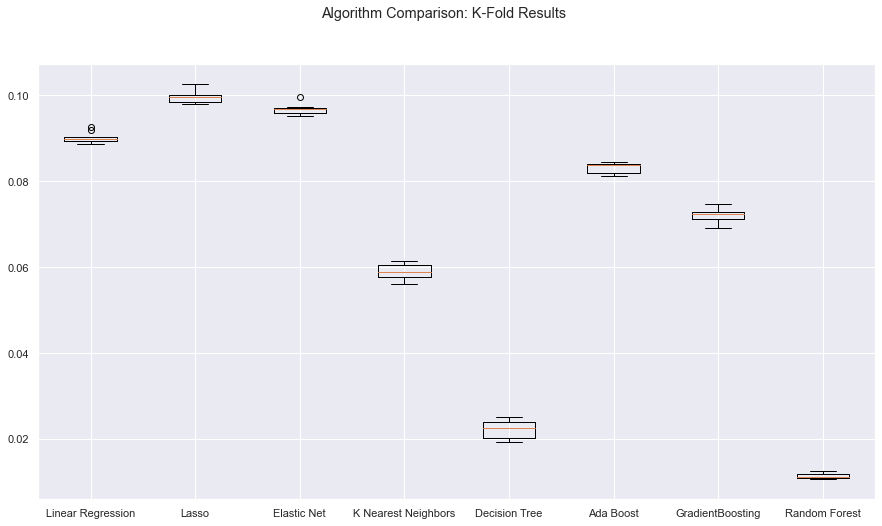

In [100]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: K-Fold Results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

- Here we can see Random Forest performs best

### Data Visualisation: Mean Squared Error Algorithm Comparison

FixedFormatter should only be used together with FixedLocator


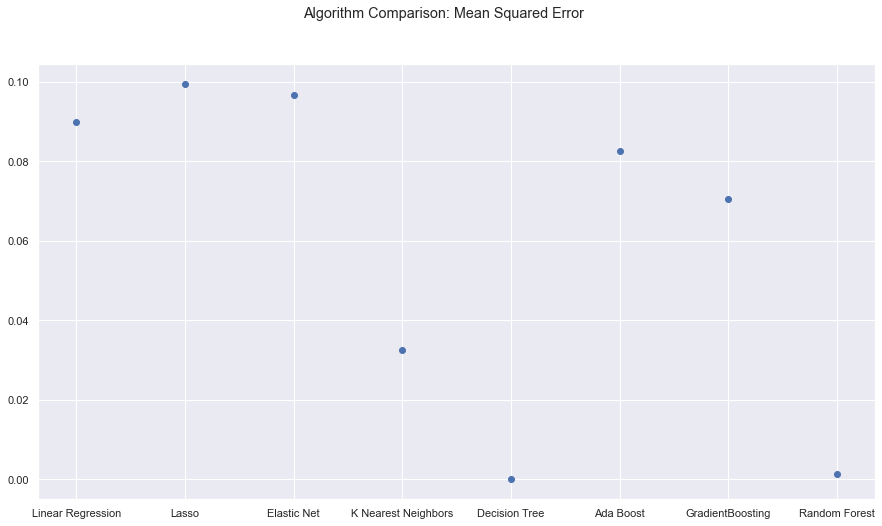

In [101]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Mean Squared Error')
ax = fig.add_subplot(111)
pyplot.scatter(names, train_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

- Even though Decison Tree seems to perform best here, taking K-Fold CV Mean Score into account Random Forest still performs best

### Data Visualisation: Overall Algorithm Comparison

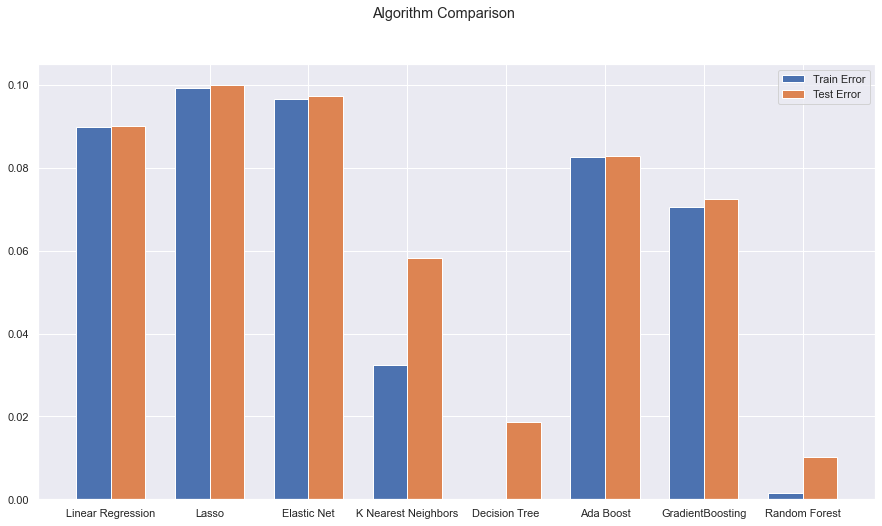

In [102]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

- Here we can see Random Forest has the lowest Train and Test error which makes it thes best performing choice
- Please keep in mind this is pre-hyper parameter tuning which will help improve the generalization 

MODEL SELECTED: **Random Forest**

# Hyperparameter Tuning

In [ ]:
# Grid search with RandomForestRegressor

'''
n_estimators : integer, optional (default=10)
    The number of trees in the forest.
'''
param_grid = {
    'n_estimators': [50,100,150,200,250],
    'max_depth' : [4,5,6],
    'max_features': [8,10]
}
model = RandomForestRegressor()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)

grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Random Forest Model

In [126]:
# Prepare model using the optimum parameters found
model = RandomForestRegressor(n_estimators = 200, max_depth = 6, max_features = 10)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, max_features=10, n_estimators=200)

# Model Performance Evaluation

## Predictions for Train and Test data

In [127]:
# Predictions for Train and Test data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

## Mean Squared Error Score

In [141]:
# Checking Generalisation and MSE Score
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
perc_diff = (mse_train - mse_test)/mse_train * 100
print(mse_train, mse_test, str(perc_diff)+"%")
print('MSE Train Score: ', mse_train)      
print('MSE Test Score: ', mse_test)
print('MSE Percentage Difference: ',str(perc_diff)+"%")

0.07135286929432615 0.07350526520468492 -3.016551305708922%
MSE Train Score:  0.07135286929432615
MSE Test Score:  0.07350526520468492
MSE Percentage Difference (Generalisation):  -3.016551305708922%


- We can see we have both a good MSE score and good generalisation

## Root Mean Squared Error Score

In [129]:
# Checking Generalisation and RMSE Score
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

perc_diff = (rmse_train - rmse_test)/rmse_train * 100
print(rmse_train, rmse_test, str(perc_diff)+"%")
print('RMSE Train Score: ', rmse_train)
print('RMSE Test Score: ', rmse_test)
print('RMSE Percentage Difference: ', str(perc_diff)+"%")

0.2671195786428358 0.27111854456064954 -1.4970695664209366%
RMSE Train Score:  0.2671195786428358
RMSE Test Score:  0.27111854456064954
RMSE Percentage Difference:  -1.4970695664209366%


- We can see we have both a good RMSE score and good generalisation

## Accuracy and Generalisation

In [140]:
train_accuracy = model.score(X_train,y_train)
test_accuracy = model.score(X_test,y_test)
print(train_accuracy)
print(test_accuracy)

0.30586379846323464
0.2888855829904803


In [146]:
Generalisation = round(abs(100*(model.score(X_test,y_test)-model.score(X_train,y_train))/model.score(X_test,y_test)),2)
print(str(Generalisation) + '%')

5.88%


# Feature Importance

In [130]:
#Using the inbuilt feature_importances for tree based classifiers
print(model.feature_importances_) 

[0.02820202 0.01060121 0.01186179 0.00482745 0.01212952 0.01195395
 0.09144728 0.01958288 0.00124907 0.00291488 0.22475174 0.02612957
 0.03215848 0.00106427 0.52112589]


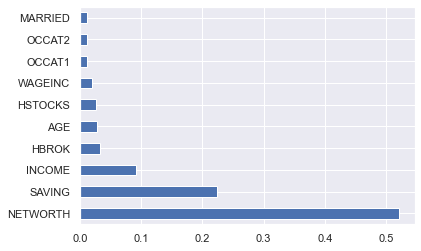

In [131]:
#Ploting the graph of feature importances for Data visualization

feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.show()

**Here we can see the top 6 most important features based on the Random Forest Model:**
1. Networth
2. Savings
3. Income
4. Whether or not one has a brokerage account
5. Age
6. Whether or not one has stocks

# Shapley Values for Model Interpretation

In [112]:
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

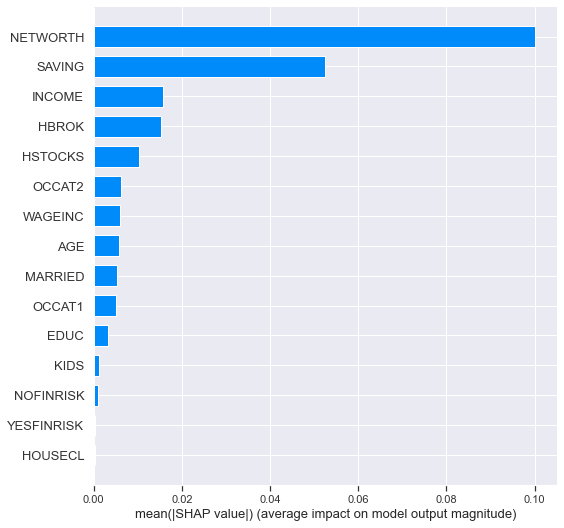

In [151]:
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

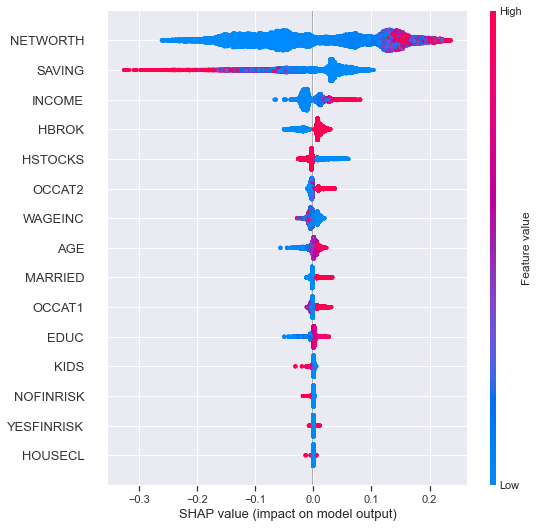

In [152]:
shap.summary_plot(shap_values, X_train)

# Limitations

# Conclusions

# Recommendations